# Dataloading

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from copy import deepcopy
from dataclasses import dataclass
from typing import List
from datetime import datetime
from collections import defaultdict
from statsmodels.stats.anova import anova_lm
from tqdm import tqdm

from qscaled.utils.configs import BaseConfig
from qscaled.utils.zip_handler import fetch_zip_data

from scripts.zip_handler import ModelSizeZipHandler
from scripts.collector import BROModelScalingCollector
from scripts.core.preprocess import (
    bootstrap_crossings_per_env,
    fill_isotonic_regression,
    compute_thresholds_per_env,
    truncate,
    remove_incomplete,
    filter_out_resets,
    manual_metrics,
)
from scripts.generate_runs.constants import DEFAULT_MAX_STEPS

from scripts.core.bootstrapping import (
    grid_best_uncertainty_bs,
    insert_predictions_shared_slope,
    plot_optimal_hparam_fit_per_env_combined_pretty,
    plot_optimal_hparam_fit_per_env_utd_pretty,
    plot_optimal_hparam_fit_per_env_n_pretty,
    predict_log_linear,
    insert_predictions,
    predict_log_linear_shared_slope,
    insert_predictions_sum_powerlaw,
    predict_sum_of_powerlaw,
    insert_predictions_inverse_power_product_log_normalize,
    predict_inverse_power_product_log_normalize,
    insert_predictions_sum_of_powerlaw_shared_exponent,
    predict_sum_of_powerlaw_shared_exponent,
)

from scripts.experiments.bro_ablations.plot_utils import (
    plot_optimal_hparam_fit_per_env_n_multiple_thresh_pretty,
    plot_optimal_hparam_fit_per_env_utd_multiple_thresh_pretty,
)

from scripts.experiments.utd_x_width_x_bs import plot_utils


import qscaled

qscaled.constants.suppress_overwrite_prompt = True

In [3]:
global_use_cached = True

In [ ]:
main_collector = BROModelScalingCollector(
    'anonymous',
    'BRO_model_scaling',
    use_cached=global_use_cached and True,
)
main_collector.remove_short()
collector = main_collector.filter('learning_rate==3e-4').flatten()

In [ ]:
batch_size_interpolated_collector = BROModelScalingCollector(
    'anonymous',
    'BRO_model_scaling',
    wandb_tags=[
        'interpolated_bs_inverse_product_250510',
        'interpolated_bs_inverse_product_250513',
        'utd3_batch_size_fit_250513',
    ],
    use_cached=global_use_cached and True,
)
batch_size_interpolated_collector.remove_short()
batch_size_interpolated_collector = batch_size_interpolated_collector.flatten()

In [ ]:
batch_size_extrapolated_collector = BROModelScalingCollector(
    'anonymous',
    'BRO_model_scaling',
    wandb_tags=['extrapolated_bs_inverse_product_250505', 'extrapolated_bs_inverse_product_250513'],
    use_cached=global_use_cached and True,
)
batch_size_extrapolated_collector.remove_short()
batch_size_extrapolated_collector = batch_size_extrapolated_collector.flatten()

In [ ]:
compute_optimal_collector = BROModelScalingCollector(
    'anonymous',
    'BRO_model_scaling',
    wandb_tags=[
        'hb_compute_optimal_250509',
        'hb_compute_optimal_250511',
        'hb_compute_optimal_250510',
    ],
    use_cached=global_use_cached and True,
)
compute_optimal_collector.remove_short()
compute_optimal_collector = compute_optimal_collector.flatten()

In [8]:
@dataclass(kw_only=True)
class ModelSizeSweepConfig(BaseConfig):
    utds_to_predict: List[float]  # UTDs to predict hyperparams for
    model_sizes_to_predict: List[int]


config_input_dict = dict(
    max_returns={},
    returns_key='return',
    utds_to_predict=[0.25, 0.5, 1, 2, 4, 8, 16, 32],
    model_sizes_to_predict=[128, 256, 512, 1024, 2048, 4096],
    thresholds=[],  # placeholder
)

config = ModelSizeSweepConfig(
    name='model_scaling_const_lr',  # Zip filename
    wandb_collector=collector,
    zip_handler_cls=ModelSizeZipHandler,
    **config_input_dict,
)

interpolated_config = ModelSizeSweepConfig(
    name='interpolated_bs_inverse_product_250510',  # Zip filename
    wandb_collector=batch_size_interpolated_collector,
    zip_handler_cls=ModelSizeZipHandler,
    **config_input_dict,
)

extrapolated_config = ModelSizeSweepConfig(
    name='extrapolated_bs_inverse_product_250505',  # Zip filename
    wandb_collector=batch_size_extrapolated_collector,
    zip_handler_cls=ModelSizeZipHandler,
    **config_input_dict,
)

compute_optimal_config = ModelSizeSweepConfig(
    name='hb_compute_optimal_250511',  # Zip filename
    wandb_collector=compute_optimal_collector,
    zip_handler_cls=ModelSizeZipHandler,
    **config_input_dict,
)

truncate_steps = DEFAULT_MAX_STEPS

In [9]:
df = fetch_zip_data(config, use_cached=global_use_cached and True)
interpolated_bs_df = fetch_zip_data(interpolated_config, use_cached=global_use_cached and True)
extrapolated_bs_df = fetch_zip_data(extrapolated_config, use_cached=global_use_cached and True)
compute_optimal_df = fetch_zip_data(compute_optimal_config, use_cached=global_use_cached and True)

In [10]:
def linear_threshold_fn(env, max_thresh):
    return np.linspace(2 / n_thresholds, 1, n_thresholds) * max_thresh


def linear_threshold_with_base(env, max_thresh):
    base = {
        'h1-crawl-v0': 450,
        'h1-pole-v0': 300,
        'h1-stand-v0': 200,
        'humanoid-stand': 300,
    }
    return np.linspace(base[env], max_thresh, n_thresholds)


n_thresholds = 20
threshold_fn_to_use = linear_threshold_with_base
threshold_description = '_linear20_with_base'

config.name += threshold_description
interpolated_config.name += threshold_description
extrapolated_config.name += threshold_description
compute_optimal_config.name += threshold_description

In [11]:
global_use_cached = True

In [12]:
def query(df, query_str):
    if query_str == '':
        return df
    else:
        return df.query(query_str)


THRESHOLD_COMPUTE_METHOD = 'best_per_utd_sigma'


def preprocess(df, config, use_cached, max_threshold_per_env=None):
    df = deepcopy(df)
    df = truncate(df, truncate_steps)
    df = df.query(
        'hard_target_update == False and target_noise_kind == "none" and use_separate_critic == False'
    )
    df = filter_out_resets(df, reset_freq=2.5e6)

    # Phase 1: Determine thresholds with a good subset of runs
    if max_threshold_per_env is None:
        complete_runs = remove_incomplete(
            df, defaultdict(lambda: 2e6, {k: 0.7 * v for k, v in DEFAULT_MAX_STEPS.items()})
        )
        complete_runs = filter_out_resets(complete_runs, reset_freq=2.5e6)
        fill_isotonic_regression(
            complete_runs,
            training_step_key='training_step_resetfilter',
            mean_return_key='mean_return_resetfilter',
        )
        max_threshold_per_env = compute_thresholds_per_env(
            complete_runs, mode=THRESHOLD_COMPUTE_METHOD
        ).to_dict()

    # Phase 2
    fill_isotonic_regression(
        df,
        training_step_key='training_step_resetfilter',
        mean_return_key='mean_return_resetfilter',
    )

    if THRESHOLD_COMPUTE_METHOD == 'worst':
        df = df[df['final_return_isotonic'] >= df['env_name'].map(max_threshold_per_env)]

    elif THRESHOLD_COMPUTE_METHOD == 'best_per_utd_sigma':
        # df = df[df['final_return_isotonic'] >= df['env_name'].map(max_threshold_per_env)]
        ...

    else:
        raise ValueError

    # Postprocessing
    df, _, thresholds_per_env = bootstrap_crossings_per_env(
        df,
        manual_thresholds=max_threshold_per_env,
        max_threshold_to_thresholds_fn=threshold_fn_to_use,
        training_step_key='training_step_resetfilter',
        return_key='return_resetfilter',
        filename=f'{config.name}_{THRESHOLD_COMPUTE_METHOD}',
        use_cached=use_cached,
    )

    df['mean_return_over_training'] = df['return_resetfilter'].apply(lambda x: np.mean(x))
    df['std_return_over_training'] = df['return_resetfilter'].apply(
        lambda x: x.mean(axis=0).std() / np.sqrt(x.shape[1])
    )

    return df, max_threshold_per_env, thresholds_per_env


powers_of_two = [2**i for i in range(1, 15)]

# determine this after running the plot
df = df.query(f'utd in [1,2,4,8] and batch_size in {powers_of_two}').query(
    'env_name == "humanoid-stand" '
    'or (env_name == "h1-pole-v0") '
    'or (env_name == "h1-crawl-v0" and batch_size >= 8 and critic_width >= 256) '
    'or (env_name == "h1-stand-v0" and critic_width >= 256 and critic_width <= 2048 and batch_size >= 128) '
)

df, max_threshold_per_env, thresholds_per_env = preprocess(
    df, config, use_cached=global_use_cached and True
)
df = manual_metrics(df)


interpolated_bs_df, _, _ = preprocess(
    interpolated_bs_df,
    interpolated_config,
    use_cached=global_use_cached and True,
    max_threshold_per_env=max_threshold_per_env,
)
interpolated_bs_df = manual_metrics(interpolated_bs_df)


extrapolated_bs_df = extrapolated_bs_df.query(
    'env_name != "h1-crawl-v0" or (env_name == "h1-crawl-v0" and critic_width >= 256)'
)

extrapolated_bs_df, _, _ = preprocess(
    extrapolated_bs_df,
    extrapolated_config,
    use_cached=global_use_cached and True,
    max_threshold_per_env=max_threshold_per_env,
)
extrapolated_bs_df = manual_metrics(extrapolated_bs_df)

compute_optimal_df, _, _ = preprocess(
    compute_optimal_df,
    compute_optimal_config,
    use_cached=global_use_cached and True,
    max_threshold_per_env=max_threshold_per_env,
)
compute_optimal_df = manual_metrics(compute_optimal_df)

Average standard deviation across all conditions: 44569.76
Average standard deviation across all conditions: 27448.93
Average standard deviation across all conditions: 25117.14
Average standard deviation across all conditions: 26812.75


In [13]:
max_threshold_per_env

{'h1-crawl-v0': 788.8871690886515,
 'h1-pole-v0': 683.1414073085136,
 'h1-stand-v0': 660.8798802573665,
 'humanoid-stand': 858.6898385806944}

In [14]:
global_use_cached = True

# Learning curves

{'h1-crawl-v0': <Figure size 1200x1500 with 24 Axes>,
 'h1-pole-v0': <Figure size 1200x1500 with 24 Axes>,
 'h1-stand-v0': <Figure size 1200x1500 with 24 Axes>,
 'humanoid-stand': <Figure size 1200x1500 with 24 Axes>}

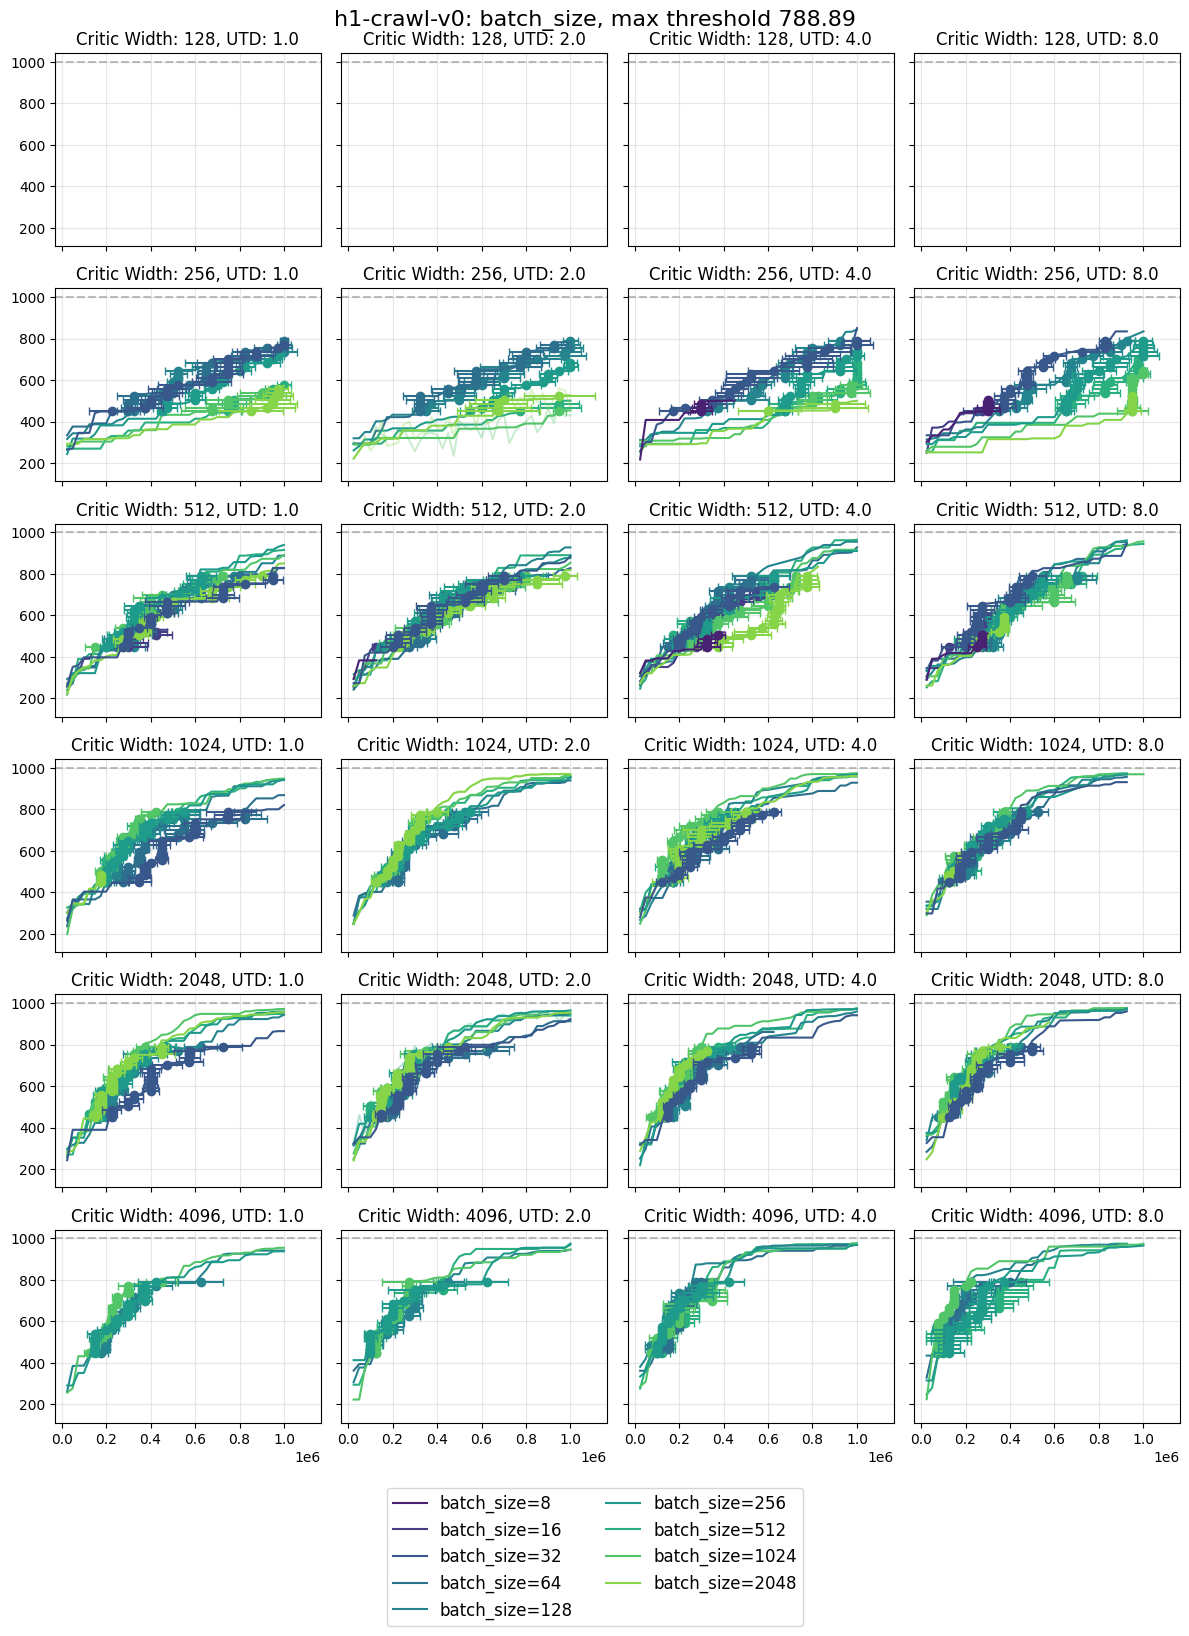

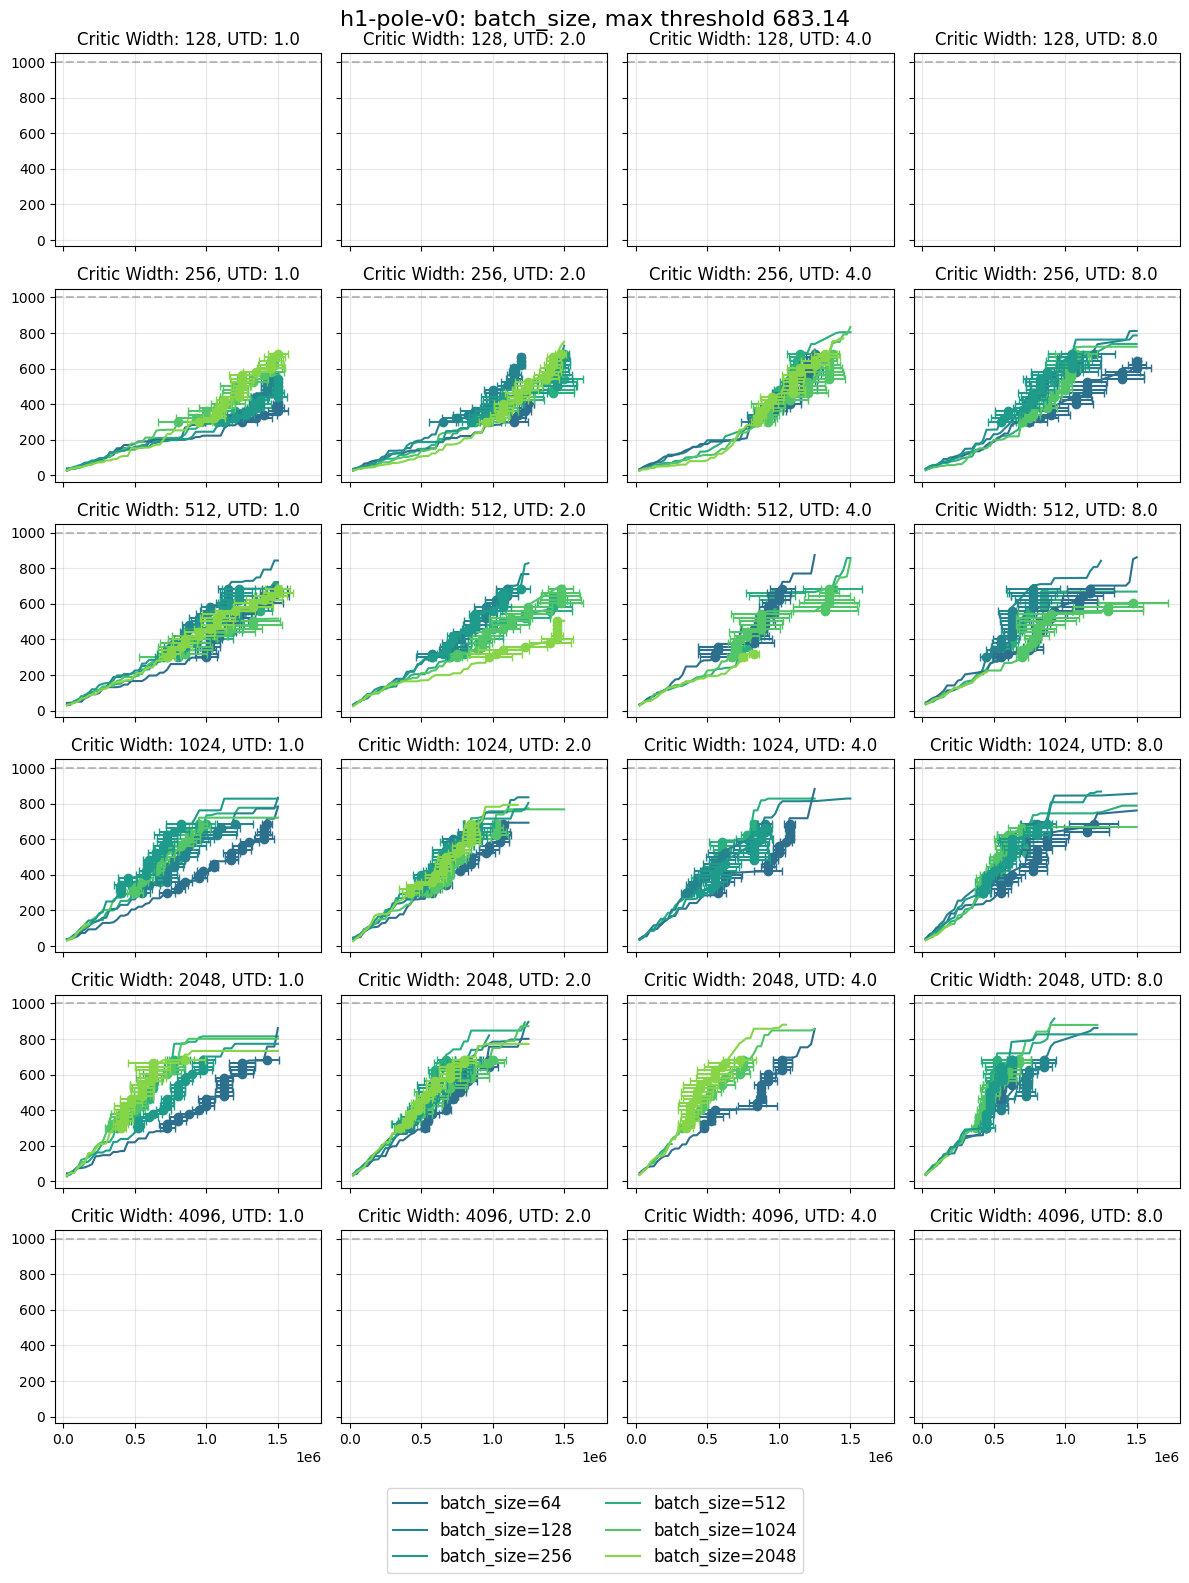

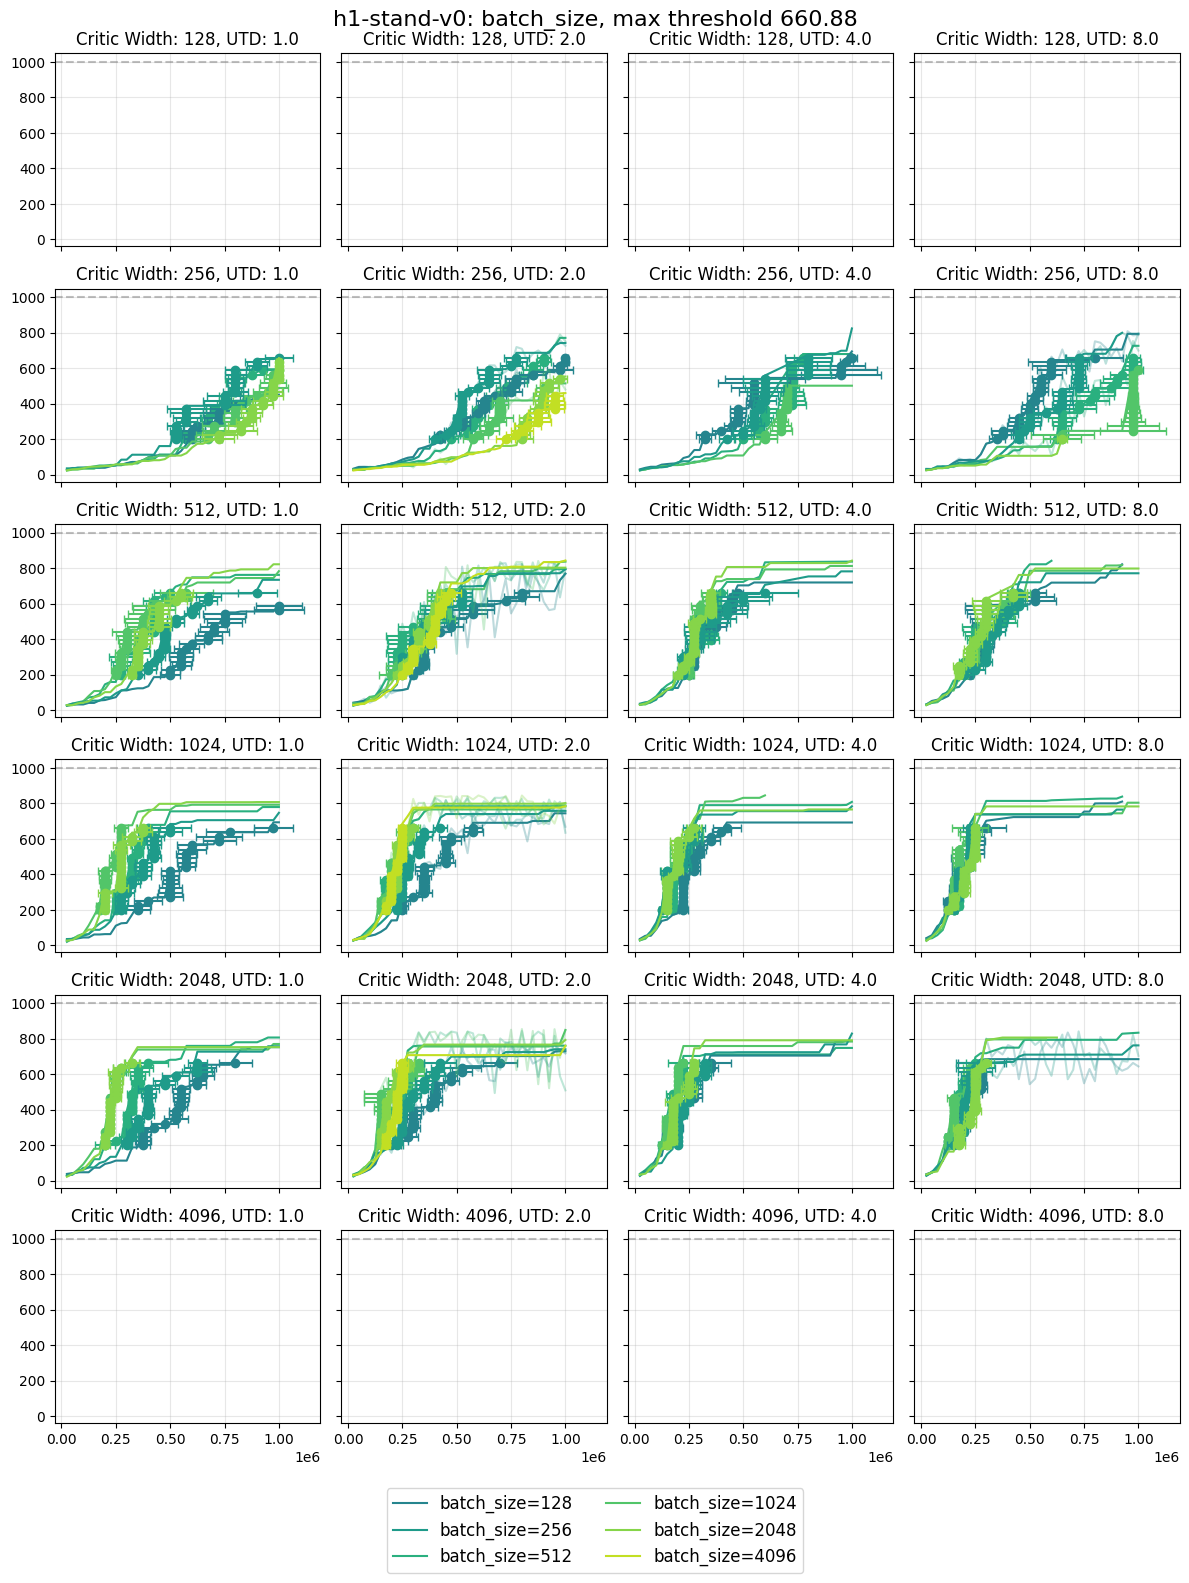

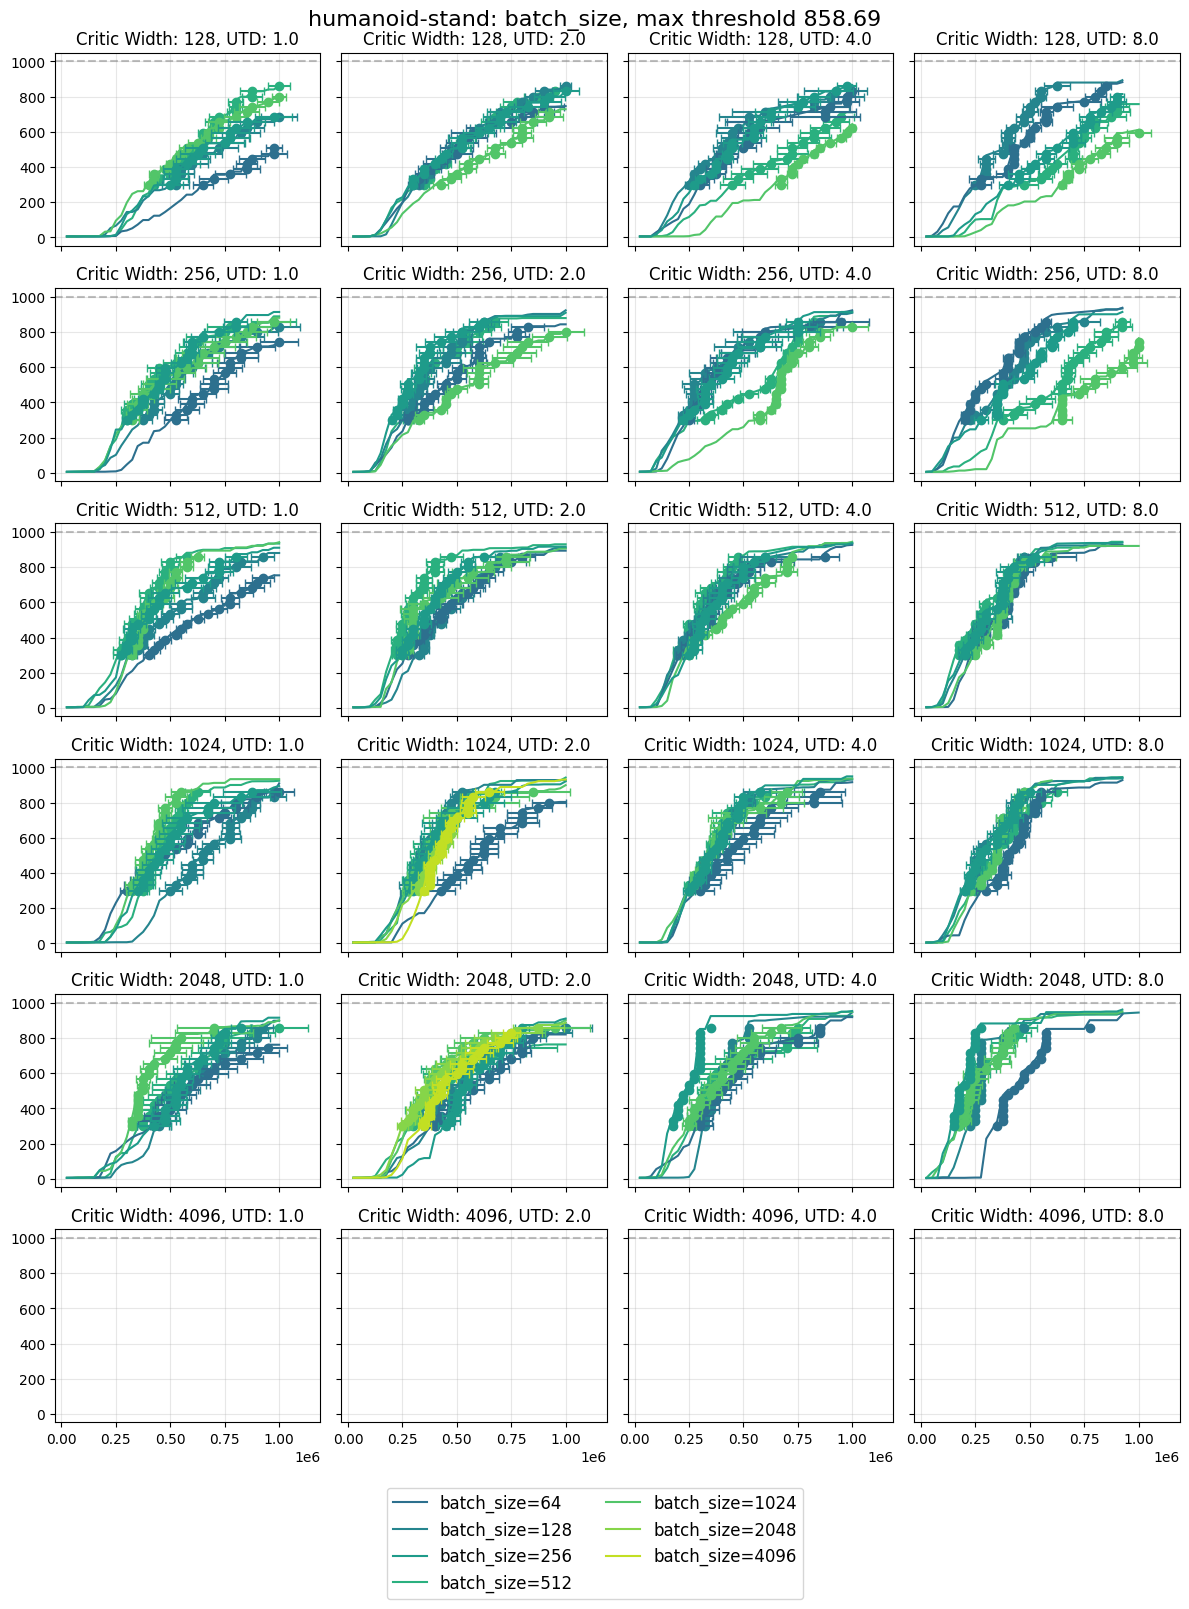

In [ ]:
plot_utils.plot_learning_curves_with_thresholds(
    df.query(
        'env_name in ["humanoid-stand", "humanoid-walk", "h1-crawl-v0", "h1-pole-v0", "h1-stand-v0", "h1-walk-v0"]'
    ),
    'batch_size',
    thresholds_per_env,
)

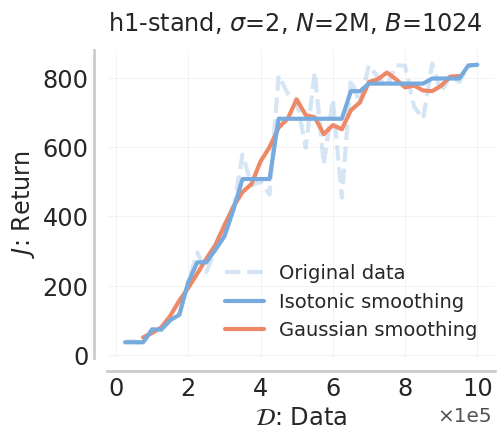

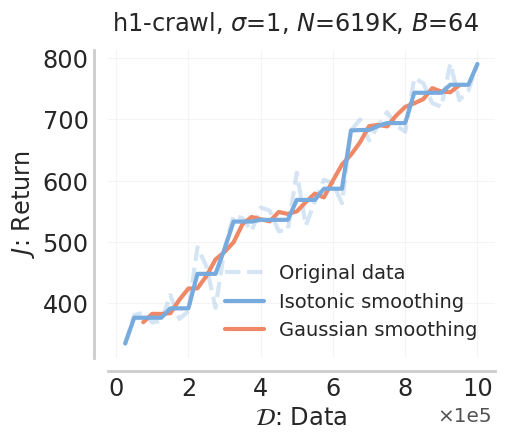

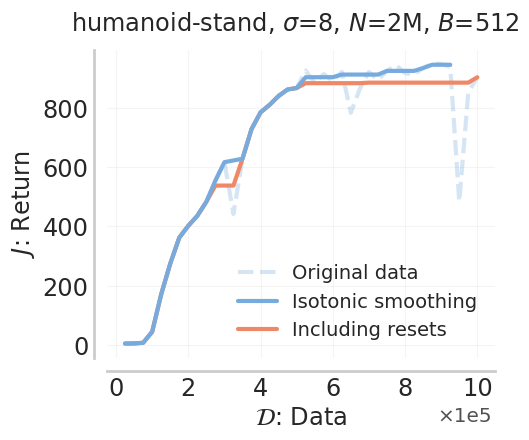

In [16]:
def plot_isotonic_samples(df):
    from sklearn.isotonic import IsotonicRegression
    from qscaled.utils import plot_utils as qscaled_plot_utils
    from rliable import plot_utils as rliable_plot_utils

    original_rc_params = plt.rcParams.copy()
    qscaled_plot_utils.set_theme()

    def plot_data(sub_df, title, filename, show_gauss=True, show_pre_reset_isotonic=True):
        fig, ax = plt.subplots(figsize=(5, 4))
        datas = pd.DataFrame(
            {'training_step': sub_df['training_step'], 'mean_return': sub_df['mean_return']}
        ).dropna()
        reset_filtered_datas = pd.DataFrame(
            {
                'training_step': sub_df['training_step_resetfilter'],
                'mean_return': sub_df['mean_return_resetfilter'],
            }
        ).dropna()

        ax.plot(
            datas['training_step'],
            datas['mean_return'],
            color=qscaled_plot_utils.COLORS[1],
            alpha=0.3,
            linestyle='--',
            label='Original data',
            linewidth=3,
        )
        ax.plot(
            sub_df['training_step_resetfilter'],
            sub_df['return_isotonic'],
            color=qscaled_plot_utils.COLORS[1],
            label='Isotonic smoothing',
            linewidth=3,
            zorder=69,
        )
        if show_gauss:
            rolling_datas = reset_filtered_datas.rolling(5, win_type='gaussian').mean(std=3)
            ax.plot(
                rolling_datas['training_step'],
                rolling_datas['mean_return'],
                color=qscaled_plot_utils.COLORS[4],
                label='Gaussian smoothing',
                linewidth=3,
            )
        elif show_pre_reset_isotonic:
            ir = IsotonicRegression(out_of_bounds='clip')
            ir.fit(datas['training_step'], datas['mean_return'])
            y_iso = ir.predict(datas['training_step'])
            ax.plot(
                datas['training_step'],
                y_iso,
                color=qscaled_plot_utils.COLORS[4],
                label='Including resets',
                linewidth=3,
            )

        rliable_plot_utils._annotate_and_decorate_axis(
            ax,
            xlabel=r'$\mathcal{D}$: Data',
            ylabel=r'$J$: Return',
            labelsize='xx-large',
            ticklabelsize='xx-large',
            grid_alpha=0.2,
            legend=False,
        )
        qscaled_plot_utils.ax_set_x_bounds_and_scale(
            ax,
            xticks=[0e5, 2e5, 4e5, 6e5, 8e5, 10e5],
            xscale='1e5',
            scale_xcoord=0.85,
            scale_ycoord=-0.22,
        )
        ax.legend(prop={'size': 14}, frameon=False, loc='lower right')
        fig.suptitle(title, fontsize='xx-large')
        plt.savefig(filename, bbox_inches='tight')
        plt.show()

    undersmooth = df.query(
        'env_name == "h1-stand-v0" and utd == 2 and critic_width == 512 and batch_size == 1024'
    )
    assert len(undersmooth) == 1
    plot_data(
        undersmooth.iloc[0],
        r'h1-stand, $\sigma$=2, $N$=2M, $B$=1024',
        '../final_plots/isotonic_undersmooth.pdf',
        show_pre_reset_isotonic=False,
    )

    oversmooth = df.query(
        'env_name == "h1-crawl-v0" and utd == 1 and critic_width == 256 and batch_size == 64'
    )
    assert len(oversmooth) == 1
    plot_data(
        oversmooth.iloc[0],
        r'h1-crawl, $\sigma$=1, $N$=619K, $B$=64',
        '../final_plots/isotonic_oversmooth.pdf',
        show_pre_reset_isotonic=False,
    )

    with_reset = df.query(
        'env_name == "humanoid-stand" and utd == 8 and critic_width == 512 and batch_size == 512'
    )
    assert len(with_reset) == 1
    plot_data(
        with_reset.iloc[0],
        r'humanoid-stand, $\sigma$=8, $N$=2M, $B$=512',
        '../final_plots/isotonic_resetfilter.pdf',
        show_gauss=False,
    )

    plt.rcParams.update(original_rc_params)


plot_isotonic_samples(df)

# Batch size fit

In [17]:
def assign_batch_size_uncertainty(df, threshold_idx=-1):
    complete_sweep = df.groupby(['env_name', 'critic_width', 'utd'])['batch_size'].count()
    valid_groups = complete_sweep[complete_sweep >= 3].index
    complete_sweep_df = (
        df.set_index(['env_name', 'critic_width', 'utd']).loc[valid_groups].reset_index()
    )
    return grid_best_uncertainty_bs(complete_sweep_df, threshold_idx)


best_bs_key = 'best_bs_bootstrap_mean'
best_bs = assign_batch_size_uncertainty(df)

In [18]:
batch_size_fit_subset_q = 'env_name in ["humanoid-stand", "h1-crawl-v0", "h1-pole-v0", "h1-stand-v0"] and utd <= 8 and critic_width <= 2048'
best_bs_subset = best_bs.query(batch_size_fit_subset_q)
df_with_best_bs_subset = pd.merge(
    df,
    best_bs_subset,
    left_on=['env_name', 'critic_width', 'critic_params', 'utd', 'batch_size', 'learning_rate'],
    right_on=['env_name', 'critic_width', 'critic_params', 'utd', 'best_bs', 'learning_rate'],
)

In [19]:
xcols = ['utd', 'critic_params']

best_bs_with_fit, (bs_model, bs_slope, bs_intercept, bs_r2) = insert_predictions(
    df_with_best_bs_subset, xcols, best_bs_key
)

best_bs_with_fit, (bs_model_shared, bs_slope_shared, bs_intercept_shared, bs_r2_shared) = (
    insert_predictions_shared_slope(best_bs_with_fit, xcols, best_bs_key)
)

predict_log_linear_ = lambda df: predict_log_linear(df, xcols, bs_slope, bs_intercept)

predict_log_linear_shared_slope_ = lambda df: predict_log_linear_shared_slope(
    df, xcols, bs_slope_shared, bs_intercept_shared
)

h1-crawl-v0: log best_bs_bootstrap_mean ~ -4.5327e+00 + -0.2967 * log utd + 0.6898 * log critic_params
h1-pole-v0: log best_bs_bootstrap_mean ~ 5.6051e+00 + -0.2388 * log utd + 0.0573 * log critic_params
h1-stand-v0: log best_bs_bootstrap_mean ~ 2.0957e+00 + -0.2698 * log utd + 0.3155 * log critic_params
humanoid-stand: log best_bs_bootstrap_mean ~ 3.4766e+00 + -0.4902 * log utd + 0.1907 * log critic_params
h1-crawl-v0: log best_bs_bootstrap_mean ~ 1.6271e+00 + -0.3336 * log utd + 0.2904 * log critic_params
h1-pole-v0: log best_bs_bootstrap_mean ~ 2.1296e+00 + -0.3336 * log utd + 0.2904 * log critic_params
h1-stand-v0: log best_bs_bootstrap_mean ~ 2.5465e+00 + -0.3336 * log utd + 0.2904 * log critic_params
humanoid-stand: log best_bs_bootstrap_mean ~ 1.8487e+00 + -0.3336 * log utd + 0.2904 * log critic_params


In [20]:
best_bs_with_fit, params_dict_product = insert_predictions_inverse_power_product_log_normalize(
    best_bs_with_fit,
    ['utd', 'critic_params'],
    best_bs_key,
    name=config.name,
    use_cached=global_use_cached and True,
    log_loss=True,
)

predict_inverse_power_product_log_normalize_ = (
    lambda df: predict_inverse_power_product_log_normalize(df, xcols, params_dict_product)
)

upward_asymptotes_product = {
    (k, utd): params[0] / utd ** params[3]
    for k, params in params_dict_product.items()
    for utd in df['utd'].unique()
}

upward_asymptotes_params_df = pd.DataFrame(
    [
        {
            'env_name': k,
            'a': params[0],
            'b': params[1],
            'c': params[2],
            'alpha': params[3],
            'a_unscaled': params[4],
            'b_unscaled': params[5],
            'c_unscaled': params[6],
        }
        for k, params in params_dict_product.items()
    ]
)

upward_asymptotes_params_df

Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base/utd_critic_params_best_bs_bootstrap_mean_inverse_power_product.npy


env_name            a             b          c     alpha  a_unscaled  \
0     h1-crawl-v0  1680.643377  8.522914e+06   1.122402  0.296694    2.301011   
1      h1-pole-v0  4112.975869  4.379864e+17   0.065870  0.238189    4.432252   
2     h1-stand-v0  1458.104221  6.767883e+05  12.713079  0.269760    1.128111   
3  humanoid-stand  1160.397921  2.734132e+06   0.379365  0.490185    1.779071   

    b_unscaled  c_unscaled  
0     1.236444    3.250566  
1  6174.143583    0.190764  
2     0.515589   36.818104  
3     1.022892    1.432473

In [21]:
def print_batch_size_eq(upward_asymptotes_params_df):
    equation_templ = (
        r'\tilde B = \dfrac{[[a]]}{\sigma^{[[\alpha]]} + [[b]] \, \sigma^{[[\alpha]]} N^{[[c]]}}'
    )
    for _, row in upward_asymptotes_params_df.iterrows():
        env_name, a, b, c, alpha = row.values[:5]
        print(
            env_name,
            equation_templ.replace(r'[[a]]', f'{a:.2f}')
            .replace(r'[[b]]', f'{b**c:.2e}')
            .replace(r'[[c]]', f'{c:.2f}')
            .replace(r'[[\alpha]]', f'{alpha:.2f}'),
        )


print_batch_size_eq(upward_asymptotes_params_df)

h1-crawl-v0 \tilde B = \dfrac{1680.64}{\sigma^{0.30} + 6.01e+07 \, \sigma^{0.30} N^{1.12}}
h1-pole-v0 \tilde B = \dfrac{4112.98}{\sigma^{0.24} + 1.45e+01 \, \sigma^{0.24} N^{0.07}}
h1-stand-v0 \tilde B = \dfrac{1458.10}{\sigma^{0.27} + 1.33e+74 \, \sigma^{0.27} N^{12.71}}
humanoid-stand \tilde B = \dfrac{1160.40}{\sigma^{0.49} + 2.77e+02 \, \sigma^{0.49} N^{0.38}}


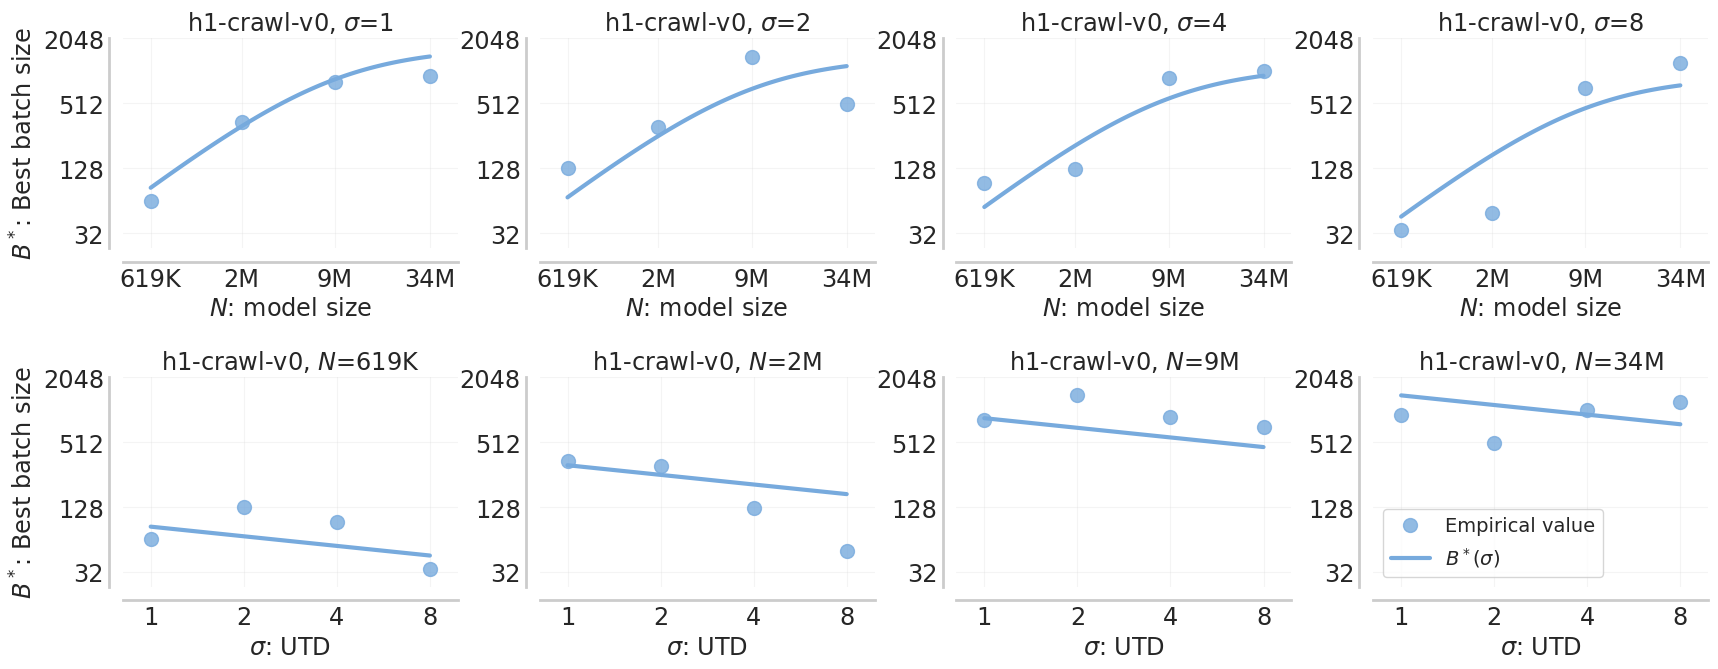

In [34]:
plot_optimal_hparam_fit_per_env_combined_pretty(
    best_bs_with_fit.query('env_name == "h1-crawl-v0"'),
    best_bs_key,
    'best_bs_bootstrap_std',
    'there is actually no title',
    [
        (
            predict_inverse_power_product_log_normalize_,
            {
                'color': 'qscaled_1',
                'label': '$B^*(\sigma)$',
            },
        ),
    ],
    yscale='log2',
    hard_ymax=2048,
    hard_ymin=8,
    save_path='../final_plots/h1-crawl-v0_batch_size_fit.pdf',
)

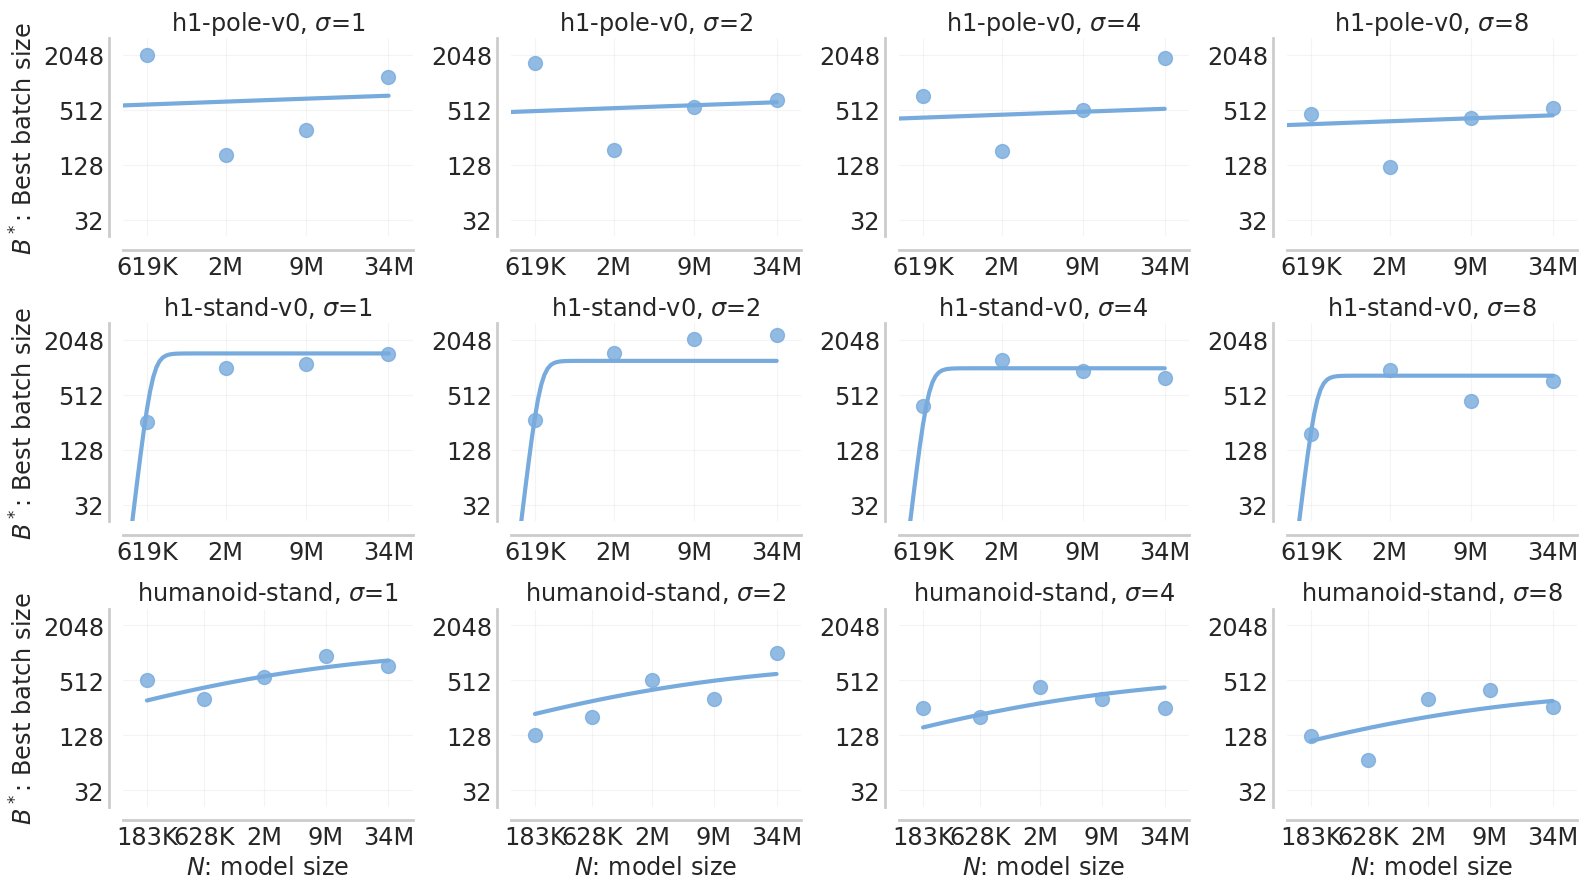

In [ ]:
plot_optimal_hparam_fit_per_env_utd_pretty(
    best_bs_with_fit.query('env_name != "h1-crawl-v0"'),
    best_bs_key,
    'best_bs_bootstrap_std',
    'there is actually no title',
    [
        (
            predict_inverse_power_product_log_normalize_,
            {
                'color': 'qscaled_1',
                'label': '$B^*(\sigma)$',
            },
        ),
    ],
    yscale='log2',
    hard_ymax=2048,
    hard_ymin=8,
    inner_axis_label=False,
    set_ylim=False,
    save_path='../final_plots/complete_batch_size_fit_grouputd.pdf',
)

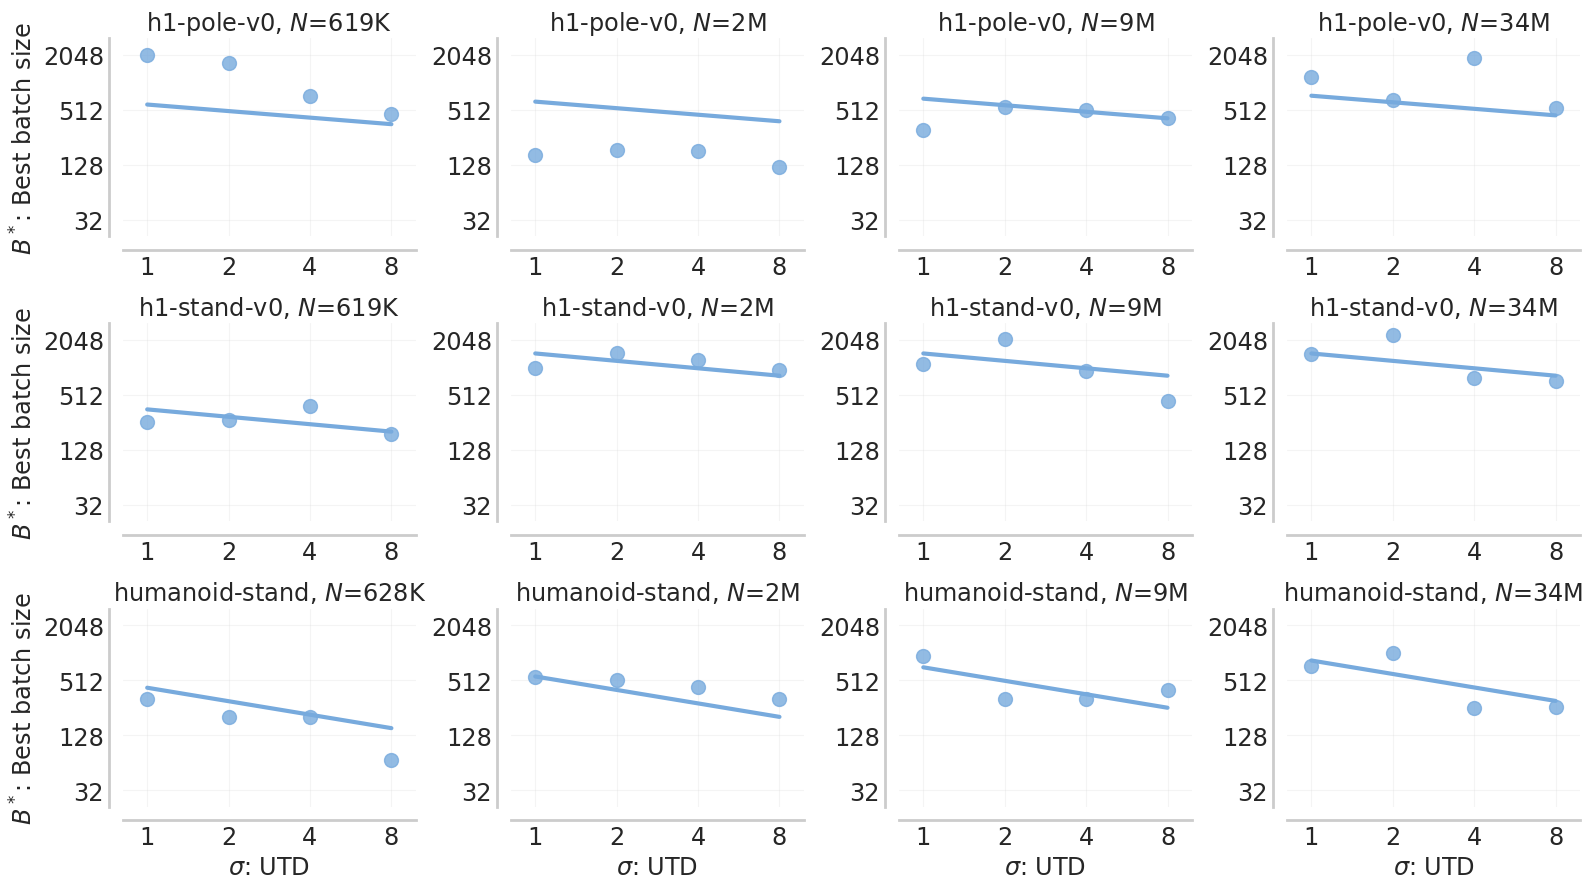

In [ ]:
plot_optimal_hparam_fit_per_env_n_pretty(
    best_bs_with_fit.query('critic_width >= 256 and env_name != "h1-crawl-v0"'),
    best_bs_key,
    'best_bs_bootstrap_std',
    'there is actually no title',
    [
        (
            predict_inverse_power_product_log_normalize_,
            {
                'color': 'qscaled_1',
                'label': '$B^*(\sigma)$',
            },
        ),
    ],
    yscale='log2',
    hard_ymax=2048,
    hard_ymin=8,
    inner_axis_label=False,
    set_ylim=False,
    save_path='../final_plots/complete_batch_size_fit_groupn.pdf',
)

# Data efficiency @ optimal batch size

## Fitting

In [40]:
def make_df_closest_fitted_batch_size(df, predict_fn):
    df = deepcopy(df)
    merge_cols = ['env_name', 'utd', 'critic_width', 'critic_params']
    df['log_batch_size'] = np.log2(df['batch_size'])

    df['fitted_batch_size'] = predict_fn(df)
    df['log_best_bs'] = np.log2(df['fitted_batch_size'])
    df.dropna(subset=['fitted_batch_size'], inplace=True)

    df = df.loc[df['crossings_bootstrap_mean'].apply(lambda x: not np.isnan(x[-1]))]
    df['batch_size_diff'] = np.abs(df['log_batch_size'] - df['log_best_bs'])
    df_closest = df.loc[df.groupby(merge_cols)['batch_size_diff'].idxmin()]
    df_closest = df_closest[
        [
            *merge_cols,
            'batch_size',
            'return_isotonic',
            'crossings',
            'crossings_bootstrap_mean',
            'crossings_bootstrap',
            'fitted_batch_size',
        ]
    ]

    df_closest['time_to_threshold_bsfit'] = df_closest['crossings_bootstrap_mean'].apply(
        lambda x: x[-1]
    )
    df_closest['time_to_threshold_bsfit_std'] = (
        df['crossings_bootstrap']
        .apply(lambda x: x[-1])
        .apply(lambda x: np.nanstd(x[x < np.inf], ddof=0))
    )
    return df_closest.rename(columns={'batch_size': 'best_bs'}).reset_index(drop=True)


df_closest_fitted_batch_size = make_df_closest_fitted_batch_size(
    df, predict_inverse_power_product_log_normalize_
)

In [42]:
data_efficiency_metric = 'time_to_threshold'

if data_efficiency_metric == 'time_to_threshold_bsfit':
    best_bs_df_for_data_fits = df_closest_fitted_batch_size
elif data_efficiency_metric == 'time_to_threshold':
    best_bs_df_for_data_fits = best_bs_with_fit
    best_bs_df_for_data_fits[f'{data_efficiency_metric}_std'] = best_bs_df_for_data_fits[
        'time_to_threshold_bootstrap'
    ].apply(lambda x: np.nanstd(x[x < np.inf], ddof=0))
else:
    raise ValueError

In [43]:
def concat_interpolated_for_data_fits(
    best_bs_df_for_data_fits, interpolated_bs_df=None, extrapolated_bs_df=None
):
    best_bs_df_for_data_fits = deepcopy(best_bs_df_for_data_fits)
    ls = [best_bs_df_for_data_fits]
    best_bs_df_for_data_fits['type'] = 'original'
    for type, df_ in [('interpolated', interpolated_bs_df), ('extrapolated', extrapolated_bs_df)]:
        if df_ is None:
            continue
        df_ = deepcopy(df_)
        df_['time_to_threshold_bsfit'] = df_['crossings'].apply(lambda x: x[-1])
        df_['time_to_threshold_bsfit_std'] = df_['crossings_bootstrap'].apply(
            lambda x: np.nanstd(x[x < np.inf], ddof=0)
        )
        df_['best_bs'] = df_['batch_size']
        df_ = df_[[c for c in best_bs_df_for_data_fits.columns if c in df_.columns]]
        df_['type'] = type
        ls.append(df_)
    return pd.concat(ls)


best_bs_df_for_data_fits = concat_interpolated_for_data_fits(
    best_bs_df_for_data_fits, interpolated_bs_df, extrapolated_bs_df
)

/home/anonymous/miniconda3/envs/scale_rl2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [45]:
(
    best_bs_df_for_data_fits,
    (
        time_to_thresh_model,
        time_to_thresh_shared_slope,
        time_to_thresh_env_intercepts,
        time_to_thresh_r2,
    ),
) = insert_predictions_shared_slope(best_bs_df_for_data_fits, xcols, data_efficiency_metric)

predict_data_efficiency_shared_slope_ = lambda df: predict_log_linear_shared_slope(
    df, xcols, time_to_thresh_shared_slope, time_to_thresh_env_intercepts
)

h1-crawl-v0: log time_to_threshold ~ 1.6135e+01 + -0.1388 * log utd + -0.1837 * log critic_params
h1-pole-v0: log time_to_threshold ~ 1.6686e+01 + -0.1388 * log utd + -0.1837 * log critic_params
h1-stand-v0: log time_to_threshold ~ 1.5829e+01 + -0.1388 * log utd + -0.1837 * log critic_params
humanoid-stand: log time_to_threshold ~ 1.6144e+01 + -0.1388 * log utd + -0.1837 * log critic_params


In [48]:
best_bs_df_for_data_fits, time_to_thresh_sum_powerlaw_params = insert_predictions_sum_powerlaw(
    best_bs_df_for_data_fits,
    xcols,
    data_efficiency_metric,
    name=config.name,
    use_cached=global_use_cached and False,
    log_loss=True,
)

predict_data_efficiency_sum_powerlaw_ = lambda df: predict_sum_of_powerlaw(
    df, xcols, time_to_thresh_sum_powerlaw_params
)

data_efficiency_sum_powerlaw_asymptotes_utd = {
    (k, utd): params[4] * (1 + (params[0] / utd) ** params[1])
    for k, params in time_to_thresh_sum_powerlaw_params.items()
    for utd in set(df['utd'].unique())
    | set(interpolated_bs_df['utd'].unique())
    | set(extrapolated_bs_df['utd'].unique())
    | set(compute_optimal_df['utd'].unique())
}

data_efficiency_sum_powerlaw_asymptotes_n = {
    (k, n): params[4] * (1 + (params[2] / n) ** params[3])
    for k, params in time_to_thresh_sum_powerlaw_params.items()
    for n in set(df['critic_params'].unique())
    | set(interpolated_bs_df['critic_params'].unique())
    | set(extrapolated_bs_df['critic_params'].unique())
    | set(compute_optimal_df['critic_params'].unique())
}

data_efficiency_sum_powerlaw_params_df = pd.DataFrame(
    [
        {
            'env_name': k,
            'a': params[0],
            'alpha': params[1],
            'b': params[2],
            'beta': params[3],
            'c': params[4],
            'alpha_unscaled': params[5],
            'beta_unscaled': params[6],
            'a_unscaled': params[7],
            'b_unscaled': params[8],
            'c_unscaled': params[9],
        }
        for k, params in time_to_thresh_sum_powerlaw_params.items()
    ]
)

data_efficiency_sum_powerlaw_params_df

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base/utd_critic_params_time_to_threshold_sum_powerlaw.npy


env_name             a     alpha             b      beta  \
0     h1-crawl-v0  2.587020e+05  0.147558  1.703041e+07  0.749474   
1      h1-pole-v0  3.224863e+06  0.269651  2.502770e+12  0.296295   
2     h1-stand-v0  6.683716e-01  2.533268  1.739012e+06  0.971628   
3  humanoid-stand  1.775606e+06  0.255039  3.749674e+07  0.627795   

               c  alpha_unscaled  beta_unscaled    a_unscaled  b_unscaled  \
0   51125.488840        0.221337       2.170537   2030.033497    1.570300   
1    9426.266722        0.404477       0.858096  10913.838879   95.540047   
2  214029.805722        3.799902       2.813913      0.382222    0.714205   
3   14854.805330        0.382559       2.370536   7331.639132    2.046399   

   c_unscaled  
0    0.089645  
1    0.009922  
2    0.485741  
3    0.023579

In [49]:
def print_data_efficiency_params(data_efficiency_sum_powerlaw_params_df):
    for _, row in data_efficiency_sum_powerlaw_params_df.iterrows():
        env_name, a, alpha, b, beta, c = row.values[:6]
        print(
            r'\texttt{[[env]]}'.replace(r'[[env]]', env_name.replace('-v0', '')),
            r'&\qquad',
            r'\mathcal D_{J_{\max}}(\sigma, N) = \mathrm{[[c]]} \left(1 + \parens{\tfrac{\mathrm{[[a]]}}{\sigma}}^{[[\alpha]]} + \parens{\tfrac{\mathrm{[[b]]}}{N}}^{[[\beta]]} \right)'.replace(
                r'[[a]]', f'{a:.2e}'
            )
            .replace(r'[[b]]', f'{b:.2e}')
            .replace(r'[[c]]', f'{c:.2e}')
            .replace(r'[[\alpha]]', f'{alpha:.2f}')
            .replace(r'[[\beta]]', f'{beta:.2f}')
            .replace('e+0', r'e')
            .replace('e-0', r'e\text{-}'),
            r'\\',
        )


print_data_efficiency_params(data_efficiency_sum_powerlaw_params_df)

\texttt{h1-crawl} &\qquad \mathcal D_{J_{\max}}(\sigma, N) = \mathrm{5.11e4} \left(1 + \parens{\tfrac{\mathrm{2.59e5}}{\sigma}}^{0.15} + \parens{\tfrac{\mathrm{1.70e7}}{N}}^{0.75} \right) \\
\texttt{h1-pole} &\qquad \mathcal D_{J_{\max}}(\sigma, N) = \mathrm{9.43e3} \left(1 + \parens{\tfrac{\mathrm{3.22e6}}{\sigma}}^{0.27} + \parens{\tfrac{\mathrm{2.50e+12}}{N}}^{0.30} \right) \\
\texttt{h1-stand} &\qquad \mathcal D_{J_{\max}}(\sigma, N) = \mathrm{2.14e5} \left(1 + \parens{\tfrac{\mathrm{6.68e\text{-}1}}{\sigma}}^{2.53} + \parens{\tfrac{\mathrm{1.74e6}}{N}}^{0.97} \right) \\
\texttt{humanoid-stand} &\qquad \mathcal D_{J_{\max}}(\sigma, N) = \mathrm{1.49e4} \left(1 + \parens{\tfrac{\mathrm{1.78e6}}{\sigma}}^{0.26} + \parens{\tfrac{\mathrm{3.75e7}}{N}}^{0.63} \right) \\


In [54]:
def check_fit_accuracy(best_bs_df_for_data_fits, interpolated_bs_df, extrapolated_bs_df, pred_fn):
    for type, df_ in [
        ('original', best_bs_df_for_data_fits),
        ('interpolated', interpolated_bs_df),
        ('extrapolated', extrapolated_bs_df),
    ]:
        pred = pred_fn(df_)
        true = df_[data_efficiency_metric]
        print(f'{type} error: {np.mean(np.abs(pred - true) / true)}')


check_fit_accuracy(
    best_bs_df_for_data_fits,
    interpolated_bs_df,
    extrapolated_bs_df,
    predict_data_efficiency_sum_powerlaw_,
)

original error: 0.10013031920902943
interpolated error: 0.1489282477759334
extrapolated error: 0.1804078052301105


In [56]:
import matplotlib.ticker as ticker


def plot_asymptotes_per_env(asymptotes):
    envs, utds = set(), set()
    for env, utd in asymptotes:
        envs.add(env)
        utds.add(utd)
    envs = sorted(list(envs))
    utds = sorted(list(utds))
    fig, axes = plt.subplots(1, len(envs), figsize=(len(envs) * 3, 3))
    for env, ax in zip(envs, axes):
        ax.set_title(env)
        env_data = [(utd, asymptotes[(env, utd)]) for utd in utds if (env, utd) in asymptotes]
        ax.plot(
            [utd for utd, _ in env_data],
            [asymptote for _, asymptote in env_data],
            marker='o',
        )
        ax.set_xscale('log')
        ax.xaxis.set_minor_locator(ticker.NullLocator())
        ax.set_xticks(utds)
    plt.tight_layout()


# plot_asymptotes_per_env(data_efficiency_shared_exponent_asymptotes)

## Iso data plot

In [ ]:
dmc_medium_averaged_params_sets = np.load(
    f'../saved_fits/dmc_multiple_thresholds_250522.npy',
    allow_pickle=True,
)
dmc_hard_averaged_params_sets = np.load(
    f'../saved_fits/dog_humanoid_multiple_thresholds_250522.npy',
    allow_pickle=True,
)

dmc_medium_last_threshold_df = pd.read_csv('../saved_fits/dmc_last_threshold_250522.csv')
dmc_hard_last_threshold_df = pd.read_csv('../saved_fits/dog_humanoid_last_threshold_250522.csv')

dmc_medium_last_threshold_df[data_efficiency_metric] = dmc_medium_last_threshold_df['time']
dmc_hard_last_threshold_df[data_efficiency_metric] = dmc_hard_last_threshold_df['time']

dmc_medium_last_threshold_df['env_name'] = 'DMC-medium'
dmc_hard_last_threshold_df['env_name'] = 'DMC-hard'

dmc_medium_highest_threshold_params = dmc_medium_averaged_params_sets[-1]['sum_powerlaw']
time_to_thresh_sum_powerlaw_params['DMC-medium'] = dmc_medium_highest_threshold_params['']

dmc_hard_highest_threshold_params = dmc_hard_averaged_params_sets[-1]['sum_powerlaw']
time_to_thresh_sum_powerlaw_params['DMC-hard'] = dmc_hard_highest_threshold_params['']

predict_data_efficiency_sum_powerlaw_ = lambda df: predict_sum_of_powerlaw(
    df, xcols, time_to_thresh_sum_powerlaw_params
)

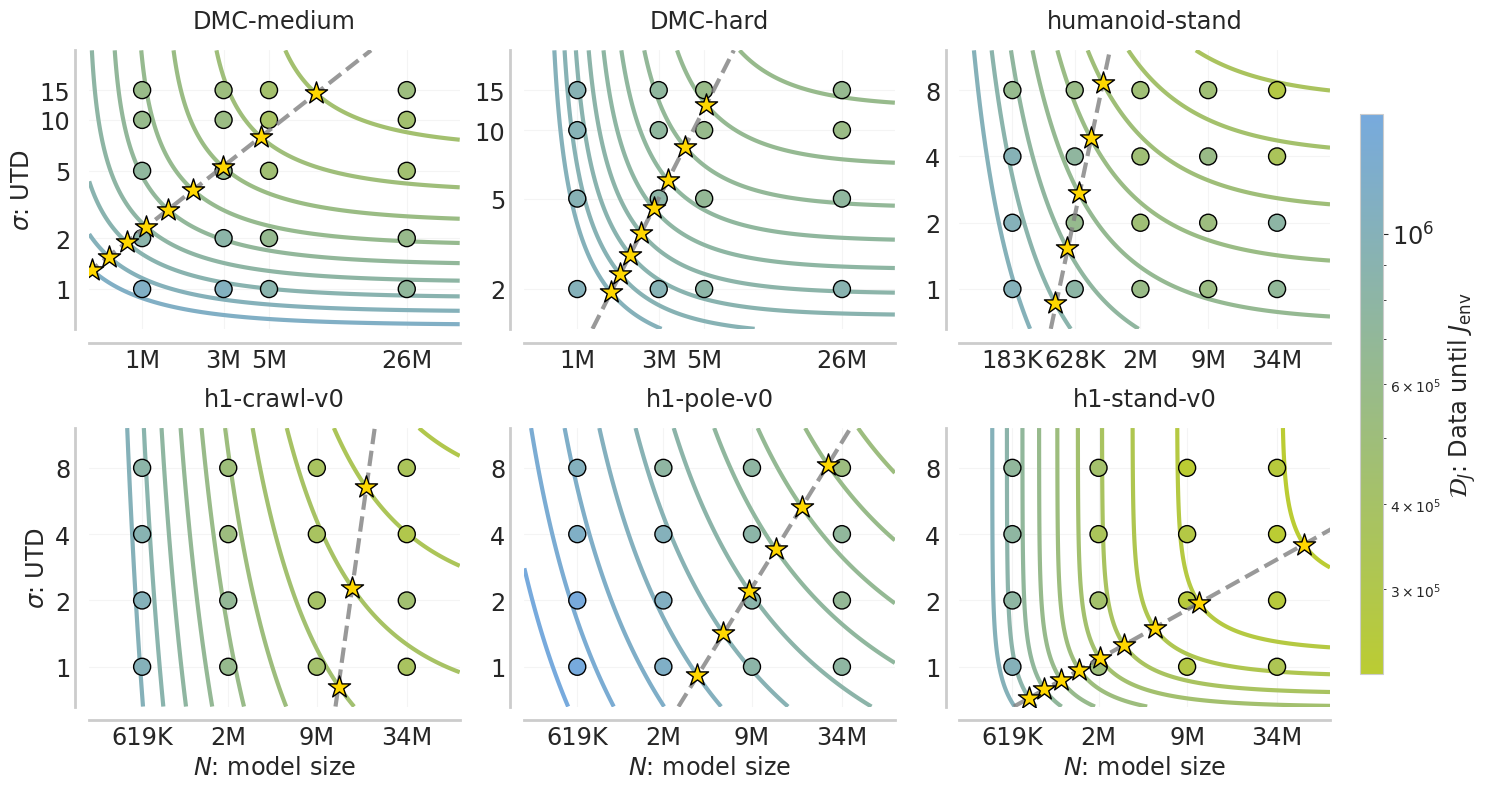

In [68]:
compute_optimal_hparams = plot_utils.plot_optimal_hparams_scatter_pretty(
    pd.concat(
        [
            best_bs_df_for_data_fits.query('type == "original"'),
            dmc_medium_last_threshold_df,
            dmc_hard_last_threshold_df,
        ]
    ),
    predict_fn=predict_data_efficiency_sum_powerlaw_,
    data_efficiency_key=data_efficiency_metric,
    mode='data_contour',
    show_optima_as_stars=True,
    show_cost_contour=False,
    params=time_to_thresh_sum_powerlaw_params,
    save_path='../final_plots/data_iso_contour.pdf',
)

In [69]:
print('UTD vs N tradeoff')
optimal_hparam_relation = plot_utils.compute_optimal_slope_and_intercept(compute_optimal_hparams)
max_length = max(len(env_name) for env_name in optimal_hparam_relation['env_name'])
for _, row in optimal_hparam_relation.iterrows():
    print(f'{row["env_name"].ljust(max_length)}   {row["eq_sigma_to_n"]}')

UTD vs N tradeoff
DMC-hard         N = 1.0582e+06 * sigma^0.6101
DMC-medium       N = 4.2043e+05 * sigma^1.1390
h1-crawl-v0      N = 1.2668e+07 * sigma^0.2046
h1-pole-v0       N = 4.1742e+06 * sigma^0.8968
h1-stand-v0      N = 1.8641e+06 * sigma^2.5953
humanoid-stand   N = 4.6219e+05 * sigma^0.4021


## Fitting multiple $J$

In [70]:
def make_multiple_crossings_df(best_bs_df_for_data_fits):
    best_bs_df_for_data_fits = deepcopy(best_bs_df_for_data_fits)
    multiple_crossings_df = best_bs_df_for_data_fits[
        [
            'env_name',
            'critic_width',
            'critic_params',
            'utd',
            'best_bs',
            'crossings',
            'crossings_bootstrap',
            'type',
        ]
    ]

    for df_ in [multiple_crossings_df]:
        for i in range(n_thresholds):
            df_[f'crossing{i}'] = df_['crossings'].apply(lambda x: x[i])
            df_[f'crossing{i}_std'] = df_['crossings_bootstrap'].apply(
                lambda x: np.nanstd(x, axis=0, ddof=0)[i]
            )
        df_['time_to_threshold'] = df_[f'crossing{n_thresholds - 1}']

    return multiple_crossings_df


generic_fit_infos = {
    'loglinear_shared': {
        'color': 'tab:orange',
        'label': r'$D \sim a_{\text{env},\sigma} \cdot N^{\beta}$',
    },
    'sum_powerlaw': {
        'color': 'tab:purple',
        'label': r'$D \sim D_{\text{min}}^{\text{env}} + \dfrac{a_{\text{env}}}{\sigma^{\alpha_{\text{env}}}} + \dfrac{b_{\text{env}}}{N^{\beta_{\text{env}}}}$',
    },
    'sum_of_powerlaw_shared_exp': {
        'color': 'darkturquoise',
        'label': r'$D \sim D_{\text{min}}^{\text{env}} + \dfrac{a_{\text{env}}}{\sigma^{\alpha}} + \dfrac{b_{\text{env}}}{N^{\beta}}$',
    },
    'sum_of_powerlaw_groupwise': {
        'color': 'crimson',
        'label': r'$\ell_2$ loss, $D_J \sim D_{\text{env}, J}^{\text{min}} + \dfrac{a_{\text{env}, J}}{\sigma^{\alpha_{\text{env}, J_g}}} + \dfrac{b_{\text{env}, J}}{N^{\beta_{\text{env}, J_g}}}$',
    },
    'sum_of_powerlaw_groupwise_p1': {
        'color': 'palevioletred',
        'label': r'$\ell_1$ loss, $D_J \sim D_{\text{env}, J}^{\text{min}} + \dfrac{a_{\text{env}, J}}{\sigma^{\alpha_{\text{env}, J_g}}} + \dfrac{b_{\text{env}, J}}{N^{\beta_{\text{env}, J_g}}}$',
    },
    'sum_of_powerlaw_groupwise_p4': {
        'color': 'darkmagenta',
        'label': r'$\ell_4$ loss, $D_J \sim D_{\text{env}, J}^{\text{min}} + \dfrac{a_{\text{env}, J}}{\sigma^{\alpha_{\text{env}, J_g}}} + \dfrac{b_{\text{env}, J}}{N^{\beta_{\text{env}, J_g}}}$',
    },
}

multiple_crossings_df = make_multiple_crossings_df(best_bs_df_for_data_fits)
time_to_thresholds_predictors = [{} for _ in range(n_thresholds)]
time_to_thresholds_infos_utd = [deepcopy(generic_fit_infos) for _ in range(n_thresholds)]
time_to_thresholds_infos_n = [deepcopy(generic_fit_infos) for _ in range(n_thresholds)]

multiple_crossings_state = (
    multiple_crossings_df,
    time_to_thresholds_predictors,
    time_to_thresholds_infos_utd,
    time_to_thresholds_infos_n,
)

/home/anonymous/miniconda3/envs/scale_rl2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/anonymous/miniconda3/envs/scale_rl2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/anonymous/miniconda3/envs/scale_rl2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/anonymous/miniconda3/envs/scale_rl2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/anonymous/miniconda3/envs/scale_rl2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedo

In [71]:
def insert_multiple_shared_slope(state, fn=insert_predictions_shared_slope):
    (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    ) = state

    fit_type = 'loglinear_shared'

    for i in range(n_thresholds):
        (
            multiple_crossings_df,
            (
                time_to_thresh_model,
                time_to_thresh_shared_slope,
                time_to_thresh_env_intercepts,
                time_to_thresh_r2,
            ),
        ) = fn(multiple_crossings_df, xcols, f'crossing{i}')

        predictor = (
            lambda params: (lambda df: predict_log_linear_shared_slope(df, xcols, *params))
        )((time_to_thresh_shared_slope, time_to_thresh_env_intercepts))
        predictors[i][fit_type] = predictor

        params = {'slope': time_to_thresh_shared_slope, 'intercept': time_to_thresh_env_intercepts}
        infos_utd[i][fit_type]['params'] = params
        infos_n[i][fit_type]['params'] = params

    return (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    )


multiple_crossings_state = insert_multiple_shared_slope(multiple_crossings_state)

h1-crawl-v0: log crossing0 ~ 1.4708e+01 + -0.1303 * log utd + -0.1593 * log critic_params
h1-pole-v0: log crossing0 ~ 1.5781e+01 + -0.1303 * log utd + -0.1593 * log critic_params
h1-stand-v0: log crossing0 ~ 1.4900e+01 + -0.1303 * log utd + -0.1593 * log critic_params
humanoid-stand: log crossing0 ~ 1.4904e+01 + -0.1303 * log utd + -0.1593 * log critic_params
h1-crawl-v0: log crossing1 ~ 1.4764e+01 + -0.1052 * log utd + -0.1590 * log critic_params
h1-pole-v0: log crossing1 ~ 1.5801e+01 + -0.1052 * log utd + -0.1590 * log critic_params
h1-stand-v0: log crossing1 ~ 1.4912e+01 + -0.1052 * log utd + -0.1590 * log critic_params
humanoid-stand: log crossing1 ~ 1.4918e+01 + -0.1052 * log utd + -0.1590 * log critic_params
h1-crawl-v0: log crossing2 ~ 1.4812e+01 + -0.0986 * log utd + -0.1567 * log critic_params
h1-pole-v0: log crossing2 ~ 1.5797e+01 + -0.0986 * log utd + -0.1567 * log critic_params
h1-stand-v0: log crossing2 ~ 1.4905e+01 + -0.0986 * log utd + -0.1567 * log critic_params
humanoi

In [72]:
def insert_multiple_sum_powerlaw(state, use_cached):
    (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    ) = state

    fit_type = 'sum_powerlaw'
    kw = dict(use_cached=global_use_cached and use_cached, log_loss=True)

    for i in tqdm(range(n_thresholds)):
        multiple_crossings_df, time_to_thresh_sum_powerlaw_params = insert_predictions_sum_powerlaw(
            multiple_crossings_df, xcols, f'crossing{i}', name=f'{config.name}_crossing{i}', **kw
        )
        predict_data_efficiency_sum_powerlaw_ = (
            lambda params: (lambda df: predict_sum_of_powerlaw(df, xcols, params))
        )(time_to_thresh_sum_powerlaw_params)

        data_efficiency_sum_powerlaw_asymptotes_utd = {
            (k, utd): params[4] * (1 + (params[0] / utd) ** params[1])
            for k, params in time_to_thresh_sum_powerlaw_params.items()
            for utd in set(df['utd'].unique())
            | set(interpolated_bs_df['utd'].unique())
            | set(extrapolated_bs_df['utd'].unique())
        }

        data_efficiency_sum_powerlaw_asymptotes_n = {
            (k, n): params[4] * (1 + (params[2] / n) ** params[3])
            for k, params in time_to_thresh_sum_powerlaw_params.items()
            for n in set(df['critic_params'].unique())
            | set(interpolated_bs_df['critic_params'].unique())
            | set(extrapolated_bs_df['critic_params'].unique())
        }

        predictors[i][fit_type] = predict_data_efficiency_sum_powerlaw_
        infos_utd[i][fit_type]['asymptote'] = data_efficiency_sum_powerlaw_asymptotes_utd
        infos_n[i][fit_type]['asymptote'] = data_efficiency_sum_powerlaw_asymptotes_n
        infos_utd[i][fit_type]['params'] = time_to_thresh_sum_powerlaw_params
        infos_n[i][fit_type]['params'] = time_to_thresh_sum_powerlaw_params

    return (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    )


multiple_crossings_state = insert_multiple_sum_powerlaw(multiple_crossings_state, use_cached=False)

  5%|▌         | 1/20 [00:00<00:06,  2.97it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing0/utd_critic_params_crossing0_sum_powerlaw.npy


 10%|█         | 2/20 [00:00<00:07,  2.51it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing1/utd_critic_params_crossing1_sum_powerlaw.npy


 15%|█▌        | 3/20 [00:01<00:06,  2.77it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing2/utd_critic_params_crossing2_sum_powerlaw.npy


 20%|██        | 4/20 [00:01<00:05,  2.97it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing3/utd_critic_params_crossing3_sum_powerlaw.npy


 25%|██▌       | 5/20 [00:01<00:04,  3.11it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing4/utd_critic_params_crossing4_sum_powerlaw.npy


 30%|███       | 6/20 [00:02<00:04,  3.14it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing5/utd_critic_params_crossing5_sum_powerlaw.npy


 35%|███▌      | 7/20 [00:02<00:04,  3.12it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing6/utd_critic_params_crossing6_sum_powerlaw.npy


 40%|████      | 8/20 [00:02<00:04,  2.59it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing7/utd_critic_params_crossing7_sum_powerlaw.npy


 45%|████▌     | 9/20 [00:03<00:04,  2.35it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing8/utd_critic_params_crossing8_sum_powerlaw.npy


 50%|█████     | 10/20 [00:03<00:04,  2.21it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing9/utd_critic_params_crossing9_sum_powerlaw.npy


 55%|█████▌    | 11/20 [00:04<00:04,  2.19it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing10/utd_critic_params_crossing10_sum_powerlaw.npy


 60%|██████    | 12/20 [00:04<00:03,  2.24it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing11/utd_critic_params_crossing11_sum_powerlaw.npy


 65%|██████▌   | 13/20 [00:05<00:03,  2.26it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing12/utd_critic_params_crossing12_sum_powerlaw.npy


 70%|███████   | 14/20 [00:05<00:02,  2.28it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing13/utd_critic_params_crossing13_sum_powerlaw.npy


 75%|███████▌  | 15/20 [00:06<00:02,  2.17it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing14/utd_critic_params_crossing14_sum_powerlaw.npy


 80%|████████  | 16/20 [00:06<00:01,  2.10it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing15/utd_critic_params_crossing15_sum_powerlaw.npy


 85%|████████▌ | 17/20 [00:07<00:01,  2.05it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing16/utd_critic_params_crossing16_sum_powerlaw.npy


 90%|█████████ | 18/20 [00:07<00:00,  2.07it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing17/utd_critic_params_crossing17_sum_powerlaw.npy


 95%|█████████▌| 19/20 [00:08<00:00,  1.87it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing18/utd_critic_params_crossing18_sum_powerlaw.npy


100%|██████████| 20/20 [00:08<00:00,  2.24it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing19/utd_critic_params_crossing19_sum_powerlaw.npy


In [73]:
def insert_multiple_sum_powerlaw_shared_exp(state, use_cached):
    (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    ) = state

    fit_type = 'sum_of_powerlaw_shared_exp'
    kw = dict(use_cached=global_use_cached and use_cached, log_loss=False)

    for i in range(n_thresholds):
        # if i != n_thresholds - 1:
        multiple_crossings_df, time_to_thresh_sum_powerlaw_shared_exponent_params = (
            insert_predictions_sum_of_powerlaw_shared_exponent(
                multiple_crossings_df,
                xcols,
                f'crossing{i}',
                name=f'{config.name}_crossing{i}',
                **kw,
            )
        )

        predict_data_efficiency_sum_powerlaw_shared_exponent_ = (
            lambda params: (lambda df: predict_sum_of_powerlaw_shared_exponent(df, xcols, params))
        )(time_to_thresh_sum_powerlaw_shared_exponent_params)

        data_efficiency_sum_powerlaw_shared_exponent_asymptotes_utd = {
            (k, utd): params[4] * (1 + (params[0] / utd) ** params[1])
            for k, params in time_to_thresh_sum_powerlaw_shared_exponent_params.items()
            for utd in set(df['utd'].unique())
            | set(interpolated_bs_df['utd'].unique())
            | set(extrapolated_bs_df['utd'].unique())
        }

        data_efficiency_sum_powerlaw_shared_exponent_asymptotes_n = {
            (k, n): params[4] * (1 + (params[2] / n) ** params[3])
            for k, params in time_to_thresh_sum_powerlaw_shared_exponent_params.items()
            for n in set(df['critic_params'].unique())
            | set(interpolated_bs_df['critic_params'].unique())
            | set(extrapolated_bs_df['critic_params'].unique())
        }

        predictors[i][fit_type] = predict_data_efficiency_sum_powerlaw_shared_exponent_
        infos_utd[i][fit_type]['asymptote'] = (
            data_efficiency_sum_powerlaw_shared_exponent_asymptotes_utd
        )
        infos_n[i][fit_type]['asymptote'] = (
            data_efficiency_sum_powerlaw_shared_exponent_asymptotes_n
        )
        infos_utd[i][fit_type]['params'] = time_to_thresh_sum_powerlaw_shared_exponent_params
        infos_n[i][fit_type]['params'] = time_to_thresh_sum_powerlaw_shared_exponent_params

    return (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    )


multiple_crossings_state = insert_multiple_sum_powerlaw_shared_exp(
    multiple_crossings_state, use_cached=True
)

Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing0/utd_critic_params_crossing0_sum_of_powerlaw_shared_exp_no_log_loss.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing1/utd_critic_params_crossing1_sum_of_powerlaw_shared_exp_no_log_loss.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing2/utd_critic_params_crossing2_sum_of_powerlaw_shared_exp_no_log_loss.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing3/utd_critic_params_crossing3_sum_of_powerlaw_shared_exp_no_log_loss.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_

/home/anonymous/model_scaling_project/single/scripts/core/bootstrapping.py:919: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[idx, f'{ycol}_sum_of_powerlaw_shared_exp'] = predict_sum_of_powerlaw_shared_exponent(
/home/anonymous/model_scaling_project/single/scripts/core/bootstrapping.py:919: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[idx, f'{ycol}_sum_of_powerlaw_shared_exp'] = predict_sum_of_powerlaw_shared_exponent(
/home/anonymous/model_scaling_project/single/scripts/core/bootstrapping.py:919: PerformanceWarni

Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing18/utd_critic_params_crossing18_sum_of_powerlaw_shared_exp_no_log_loss.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/model_scaling_const_lr_linear20_with_base_crossing19/utd_critic_params_crossing19_sum_of_powerlaw_shared_exp_no_log_loss.npy


/home/anonymous/model_scaling_project/single/scripts/core/bootstrapping.py:919: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[idx, f'{ycol}_sum_of_powerlaw_shared_exp'] = predict_sum_of_powerlaw_shared_exponent(


In [78]:
(
    multiple_crossings_df,
    time_to_thresholds_predictors,
    time_to_thresholds_infos_utd,
    time_to_thresholds_infos_n,
) = multiple_crossings_state

/tmp/ipykernel_95985/2121380860.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  multiple_crossings_df['batch_size'] = multiple_crossings_df['best_bs']


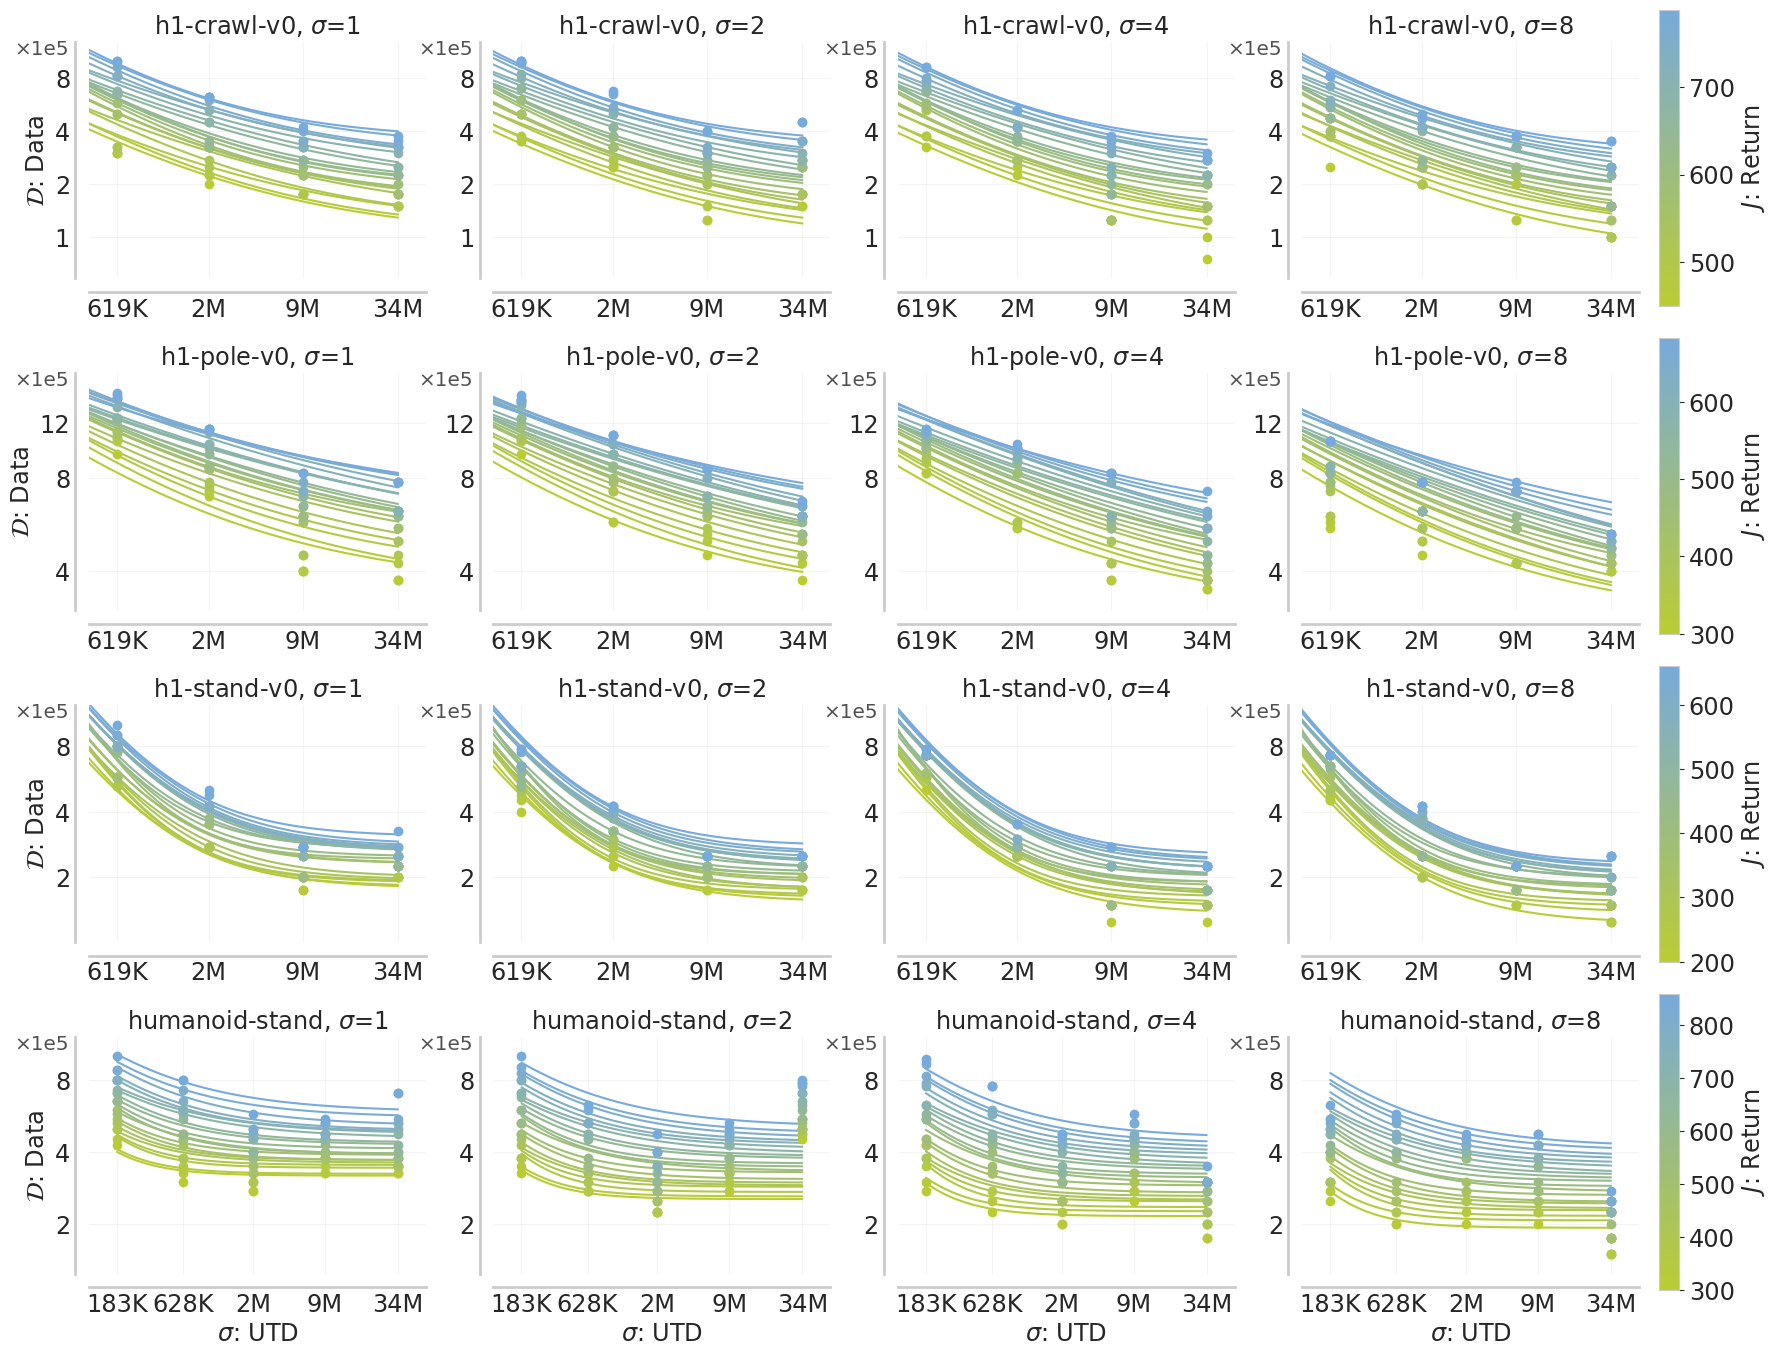

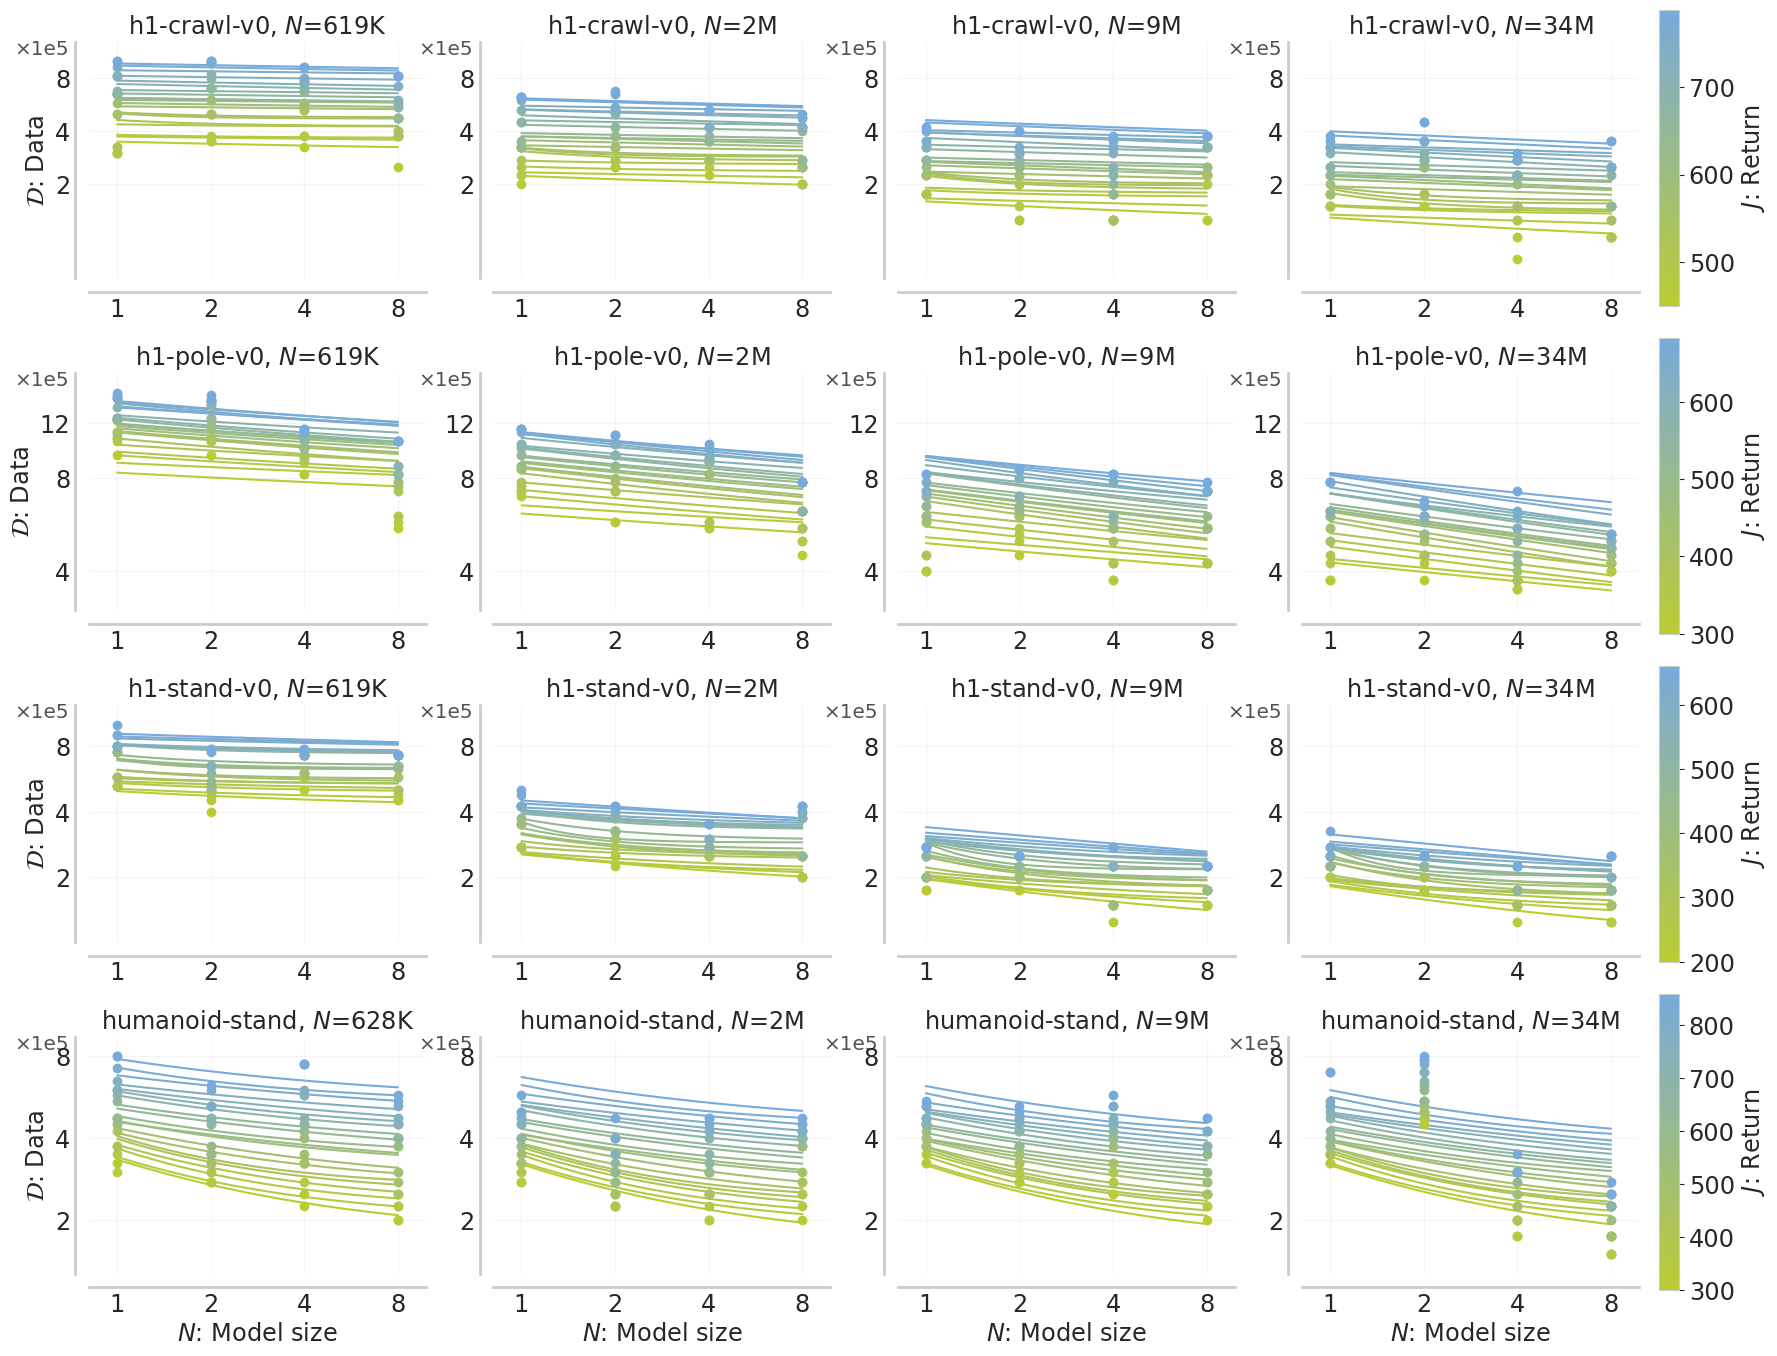

In [80]:
def plot_multiple_data_efficiency(multiple_crossings_state, fit_type):
    (
        multiple_crossings_df,
        time_to_thresholds_predictors,
        time_to_thresholds_infos_utd,
        time_to_thresholds_infos_n,
    ) = multiple_crossings_state

    multiple_crossings_df = multiple_crossings_df.query('type == "original"')
    multiple_crossings_df['batch_size'] = multiple_crossings_df['best_bs']
    dfs_list = []
    for i in range(n_thresholds):
        cols = [
            'env_name',
            'critic_width',
            'critic_params',
            'utd',
            'batch_size',
            f'crossing{i}',
            f'crossing{i}_std',
        ]
        dfs_list.append(
            multiple_crossings_df[cols].rename(
                columns={f'crossing{i}': 'time', f'crossing{i}_std': 'time_std'}
            )
        )

    plot_optimal_hparam_fit_per_env_utd_multiple_thresh_pretty(
        dfs_list,
        'time',
        'time_std',
        'Time to threshold',
        thresholds_per_env,
        [
            (time_to_thresholds_predictors[i][fit_type], time_to_thresholds_infos_utd[i][fit_type])
            for i in range(n_thresholds)
        ],
        yticks={
            'h1-crawl-v0': [1e5, 2e5, 4e5, 8e5],
            'h1-pole-v0': [4e5, 8e5, 12e5],
            'h1-stand-v0': [2e5, 4e5, 8e5],
            'humanoid-stand': [2e5, 4e5, 8e5],
        },
        save_path='../final_plots/data_fit_multi_thresh_sigma.pdf',
    )

    plot_optimal_hparam_fit_per_env_n_multiple_thresh_pretty(
        [x.query('critic_width >= 256') for x in dfs_list],
        'time',
        'time_std',
        'Time to threshold',
        thresholds_per_env,
        [
            (time_to_thresholds_predictors[i][fit_type], time_to_thresholds_infos_utd[i][fit_type])
            for i in range(n_thresholds)
        ],
        yticks={
            'h1-crawl-v0': [2e5, 4e5, 8e5],
            'h1-pole-v0': [4e5, 8e5, 12e5],
            'h1-stand-v0': [2e5, 4e5, 8e5],
            'humanoid-stand': [2e5, 4e5, 8e5],
        },
        group_col='critic_width',
        save_path='../final_plots/data_fit_multi_thresh_n.pdf',
    )


plot_multiple_data_efficiency(multiple_crossings_state, 'sum_powerlaw')

# Budget optimal

In [ ]:
delta_dict = {
    'h1-crawl-v0': '2e12',
    'h1-stand-v0': '5e11',
    'h1-pole-v0': '5e11',
    'humanoid-stand': '5e10',
}

In [91]:
def compute_multiple_optimal_budget(multiple_crossings_df, param_sets, delta_dict, use_cached):
    results = []
    for env, group in multiple_crossings_df.groupby('env_name'):
        delta_str = delta_dict[env]

        cache_file = f'budget_optimal/{config.name}/multiple_budget_optimal_hparams_{env}_{delta_str}_250514.csv'
        # cache_file = {

        # }
        if use_cached and os.path.exists(cache_file):
            env_hparams = pd.read_csv(cache_file)
        else:
            env_hparams = plot_utils.compute_optimal_budget(
                group,
                params_per_thresh=[
                    param_sets[i]['sum_powerlaw']['params'] for i in range(n_thresholds)
                ],
                data_efficiency_key_prefix='crossing',
                delta=float(delta_str),
            )
            outfile = f'dump/{config.name}/multiple_budget_optimal_hparams_{env}_{delta_str}_{datetime.now().strftime("%y%m%d_%H%M%S")}.csv'
            print(outfile)
            os.makedirs(os.path.dirname(outfile), exist_ok=True)
            env_hparams.to_csv(outfile, index=False)
        results.append(env_hparams)
    return pd.concat(results)


multiple_budget_optimal_hparams = compute_multiple_optimal_budget(
    multiple_crossings_df, time_to_thresholds_infos_utd, delta_dict, use_cached=False
)

100%|██████████| 20/20 [00:00<00:00, 360.41it/s]


dump/model_scaling_const_lr_linear20_with_base/multiple_budget_optimal_hparams_h1-crawl-v0_2e12_250523_023247.csv


100%|██████████| 20/20 [00:00<00:00, 368.87it/s]


dump/model_scaling_const_lr_linear20_with_base/multiple_budget_optimal_hparams_h1-pole-v0_5e11_250523_023247.csv


100%|██████████| 20/20 [00:00<00:00, 436.77it/s]


dump/model_scaling_const_lr_linear20_with_base/multiple_budget_optimal_hparams_h1-stand-v0_5e11_250523_023247.csv


100%|██████████| 20/20 [00:00<00:00, 463.61it/s]

dump/model_scaling_const_lr_linear20_with_base/multiple_budget_optimal_hparams_humanoid-stand_5e10_250523_023248.csv


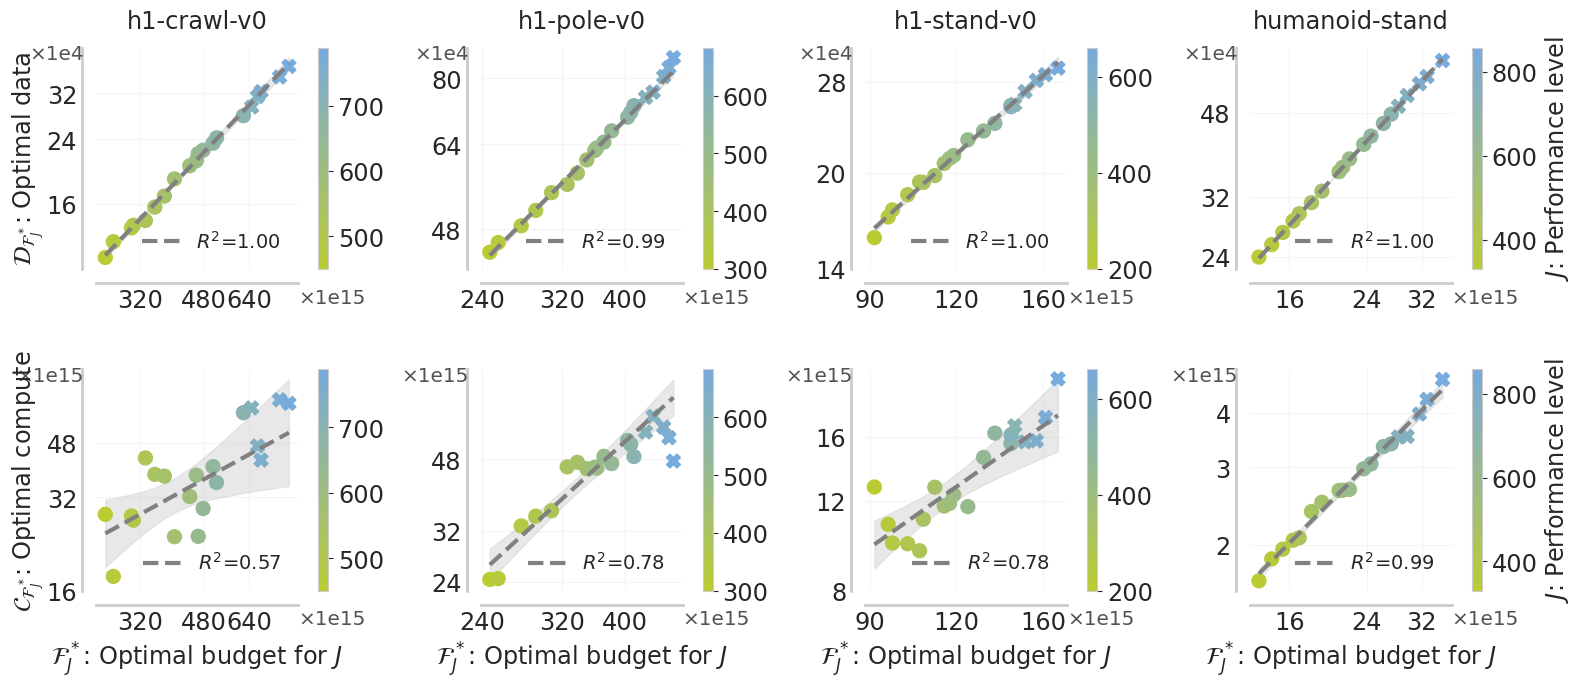

In [94]:
plot_utils.plot_budget_data_compute_opt_pretty(
    multiple_budget_optimal_hparams.query(
        '(env_name=="humanoid-stand" and threshold_idx>0) or (env_name!="humanoid-stand")'
    ),
    delta_dict,
    thresholds_per_env,
    xticks={
        'h1-crawl-v0': [32e16, 48e16, 64e16],
        'h1-pole-v0': [24e16, 32e16, 40e16],
        'h1-stand-v0': [9e16, 12e16, 16e16],
        'humanoid-stand': [1.6e16, 2.4e16, 3.2e16],
    },
    xscale='1e15',
    data_yticks={
        'h1-crawl-v0': [16e4, 24e4, 32e4],
        'h1-pole-v0': [48e4, 64e4, 80e4],
        'h1-stand-v0': [14e4, 20e4, 28e4],
        'humanoid-stand': [24e4, 32e4, 48e4],
    },
    data_yscale='1e4',
    compute_yticks={
        'h1-crawl-v0': [16e15, 32e15, 48e15],
        'h1-pole-v0': [24e15, 32e15, 48e15],
        'h1-stand-v0': [8e15, 12e15, 16e15],
        'humanoid-stand': [2e15, 3e15, 4e15],
    },
    compute_yscale='1e15',
    num_extrapolated_points=5,
    save_path='../final_plots/budget_data_compute_opt.pdf',
)

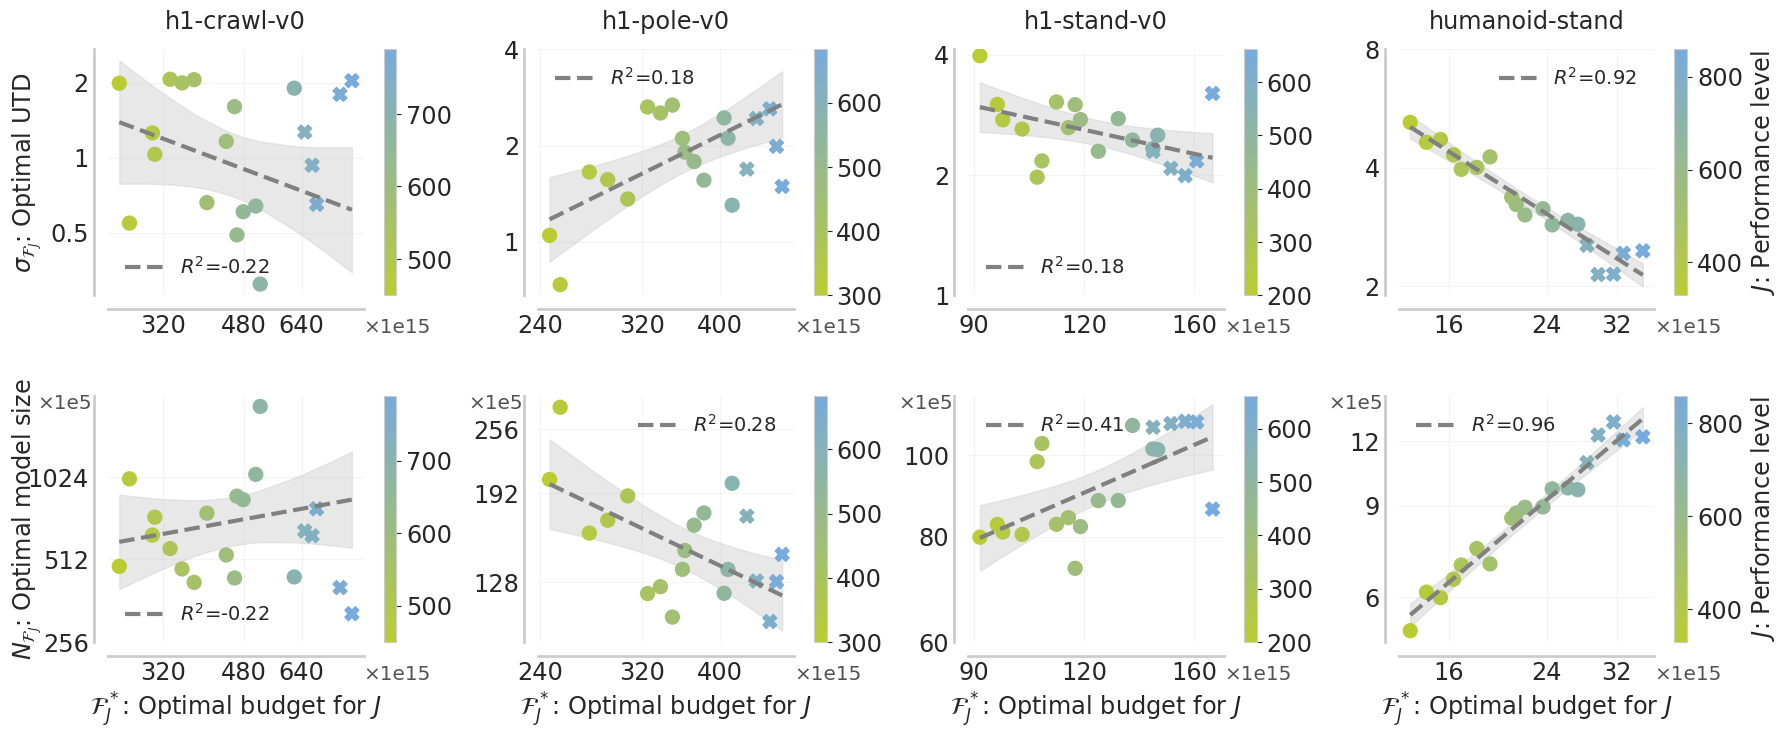

In [104]:
plot_subset_budget_n_sigma_opt = False

plot_utils.plot_budget_n_sigma_opt_pretty(
    multiple_budget_optimal_hparams.query(
        '(env_name=="humanoid-stand" and threshold_idx>0) or (env_name!="humanoid-stand")'
        + (
            ' and (env_name in ["h1-pole-v0", "humanoid-stand"])'
            if plot_subset_budget_n_sigma_opt
            else ''
        )
    ),
    delta_dict,
    thresholds_per_env,
    xticks={
        'h1-crawl-v0': [32e16, 48e16, 64e16],
        'h1-pole-v0': [24e16, 32e16, 40e16],
        'h1-stand-v0': [9e16, 12e16, 16e16],
        'humanoid-stand': [1.6e16, 2.4e16, 3.2e16],
    },
    xscale='1e15',
    sigma_yticks={
        'h1-crawl-v0': [0.5, 1.0, 2.0],
        'h1-pole-v0': [1.0, 2.0, 4.0],
        'h1-stand-v0': [1.0, 2.0, 4.0],
        'humanoid-stand': [2.0, 4.0, 8.0],
    },
    sigma_yscale='1',
    n_yticks={
        'h1-crawl-v0': [256e5, 512e5, 1024e5],
        'h1-pole-v0': [128e5, 192e5, 256e5],
        'h1-stand-v0': [60e5, 80e5, 100e5],
        'humanoid-stand': [6e5, 9e5, 12e5],
    },
    n_yscale='1e5',
    num_extrapolated_points=5,
    save_path='../final_plots/budget_sigma_n_opt_subset.pdf'
    if plot_subset_budget_n_sigma_opt
    else '../final_plots/budget_sigma_n_opt.pdf',
)